In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time 

Load dataset

In [2]:
fileName = 'complete_dataset.csv'
demand_dataset = pd.read_csv(fileName)

Data preprocessing - change school_day and holiday into binary variable

In [3]:

demand_dataset['school_day'] = demand_dataset['school_day'].replace({'Y':1, 'N':0})
demand_dataset['holiday'] = demand_dataset['holiday'].replace({'Y':1, 'N':0})
demand_dataset[25:30]


date      demand        RRP  demand_pos_RRP  RRP_positive  \
25  2015-01-26  103769.480  16.936013      103769.480     16.936013   
26  2015-01-27  118393.310  21.206289      118393.310     21.206289   
27  2015-01-28  116763.725  17.023838      116763.725     17.023838   
28  2015-01-29  119313.730  19.624827      119313.730     19.624827   
29  2015-01-30  121018.150  21.029356      121018.150     21.029356   

    demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
25             0.0           0.0              0.0             11.6   
26             0.0           0.0              0.0             11.7   
27             0.0           0.0              0.0             13.3   
28             0.0           0.0              0.0             12.8   
29             0.0           0.0              0.0             13.1   

    max_temperature  solar_exposure  rainfall  school_day  holiday  
25             19.8            19.9       1.0           0        1  
26             19.1            17.7       0.6           0        0  
27             25.4            27.0       0.0           0        0  
28             22.2            28.9       0.0           1        0  
29             21.0            27.6       0.0           1        0

Fill missing values

In [4]:
df = demand_dataset.drop(['date'], axis=1)
df.at[161, 'rainfall'] = 0
df.at[1377, 'rainfall'] = 0.4
df.at[1378, 'rainfall'] = 3.4
df['solar_exposure'].fillna(method = 'ffill', inplace = True)
print(df.isnull().sum())

demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64


C:\Users\AB\AppData\Local\Temp\ipykernel_15888\3896398393.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['solar_exposure'].fillna(method = 'ffill', inplace = True)


Scatter plot of relationships between chosen variables

c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

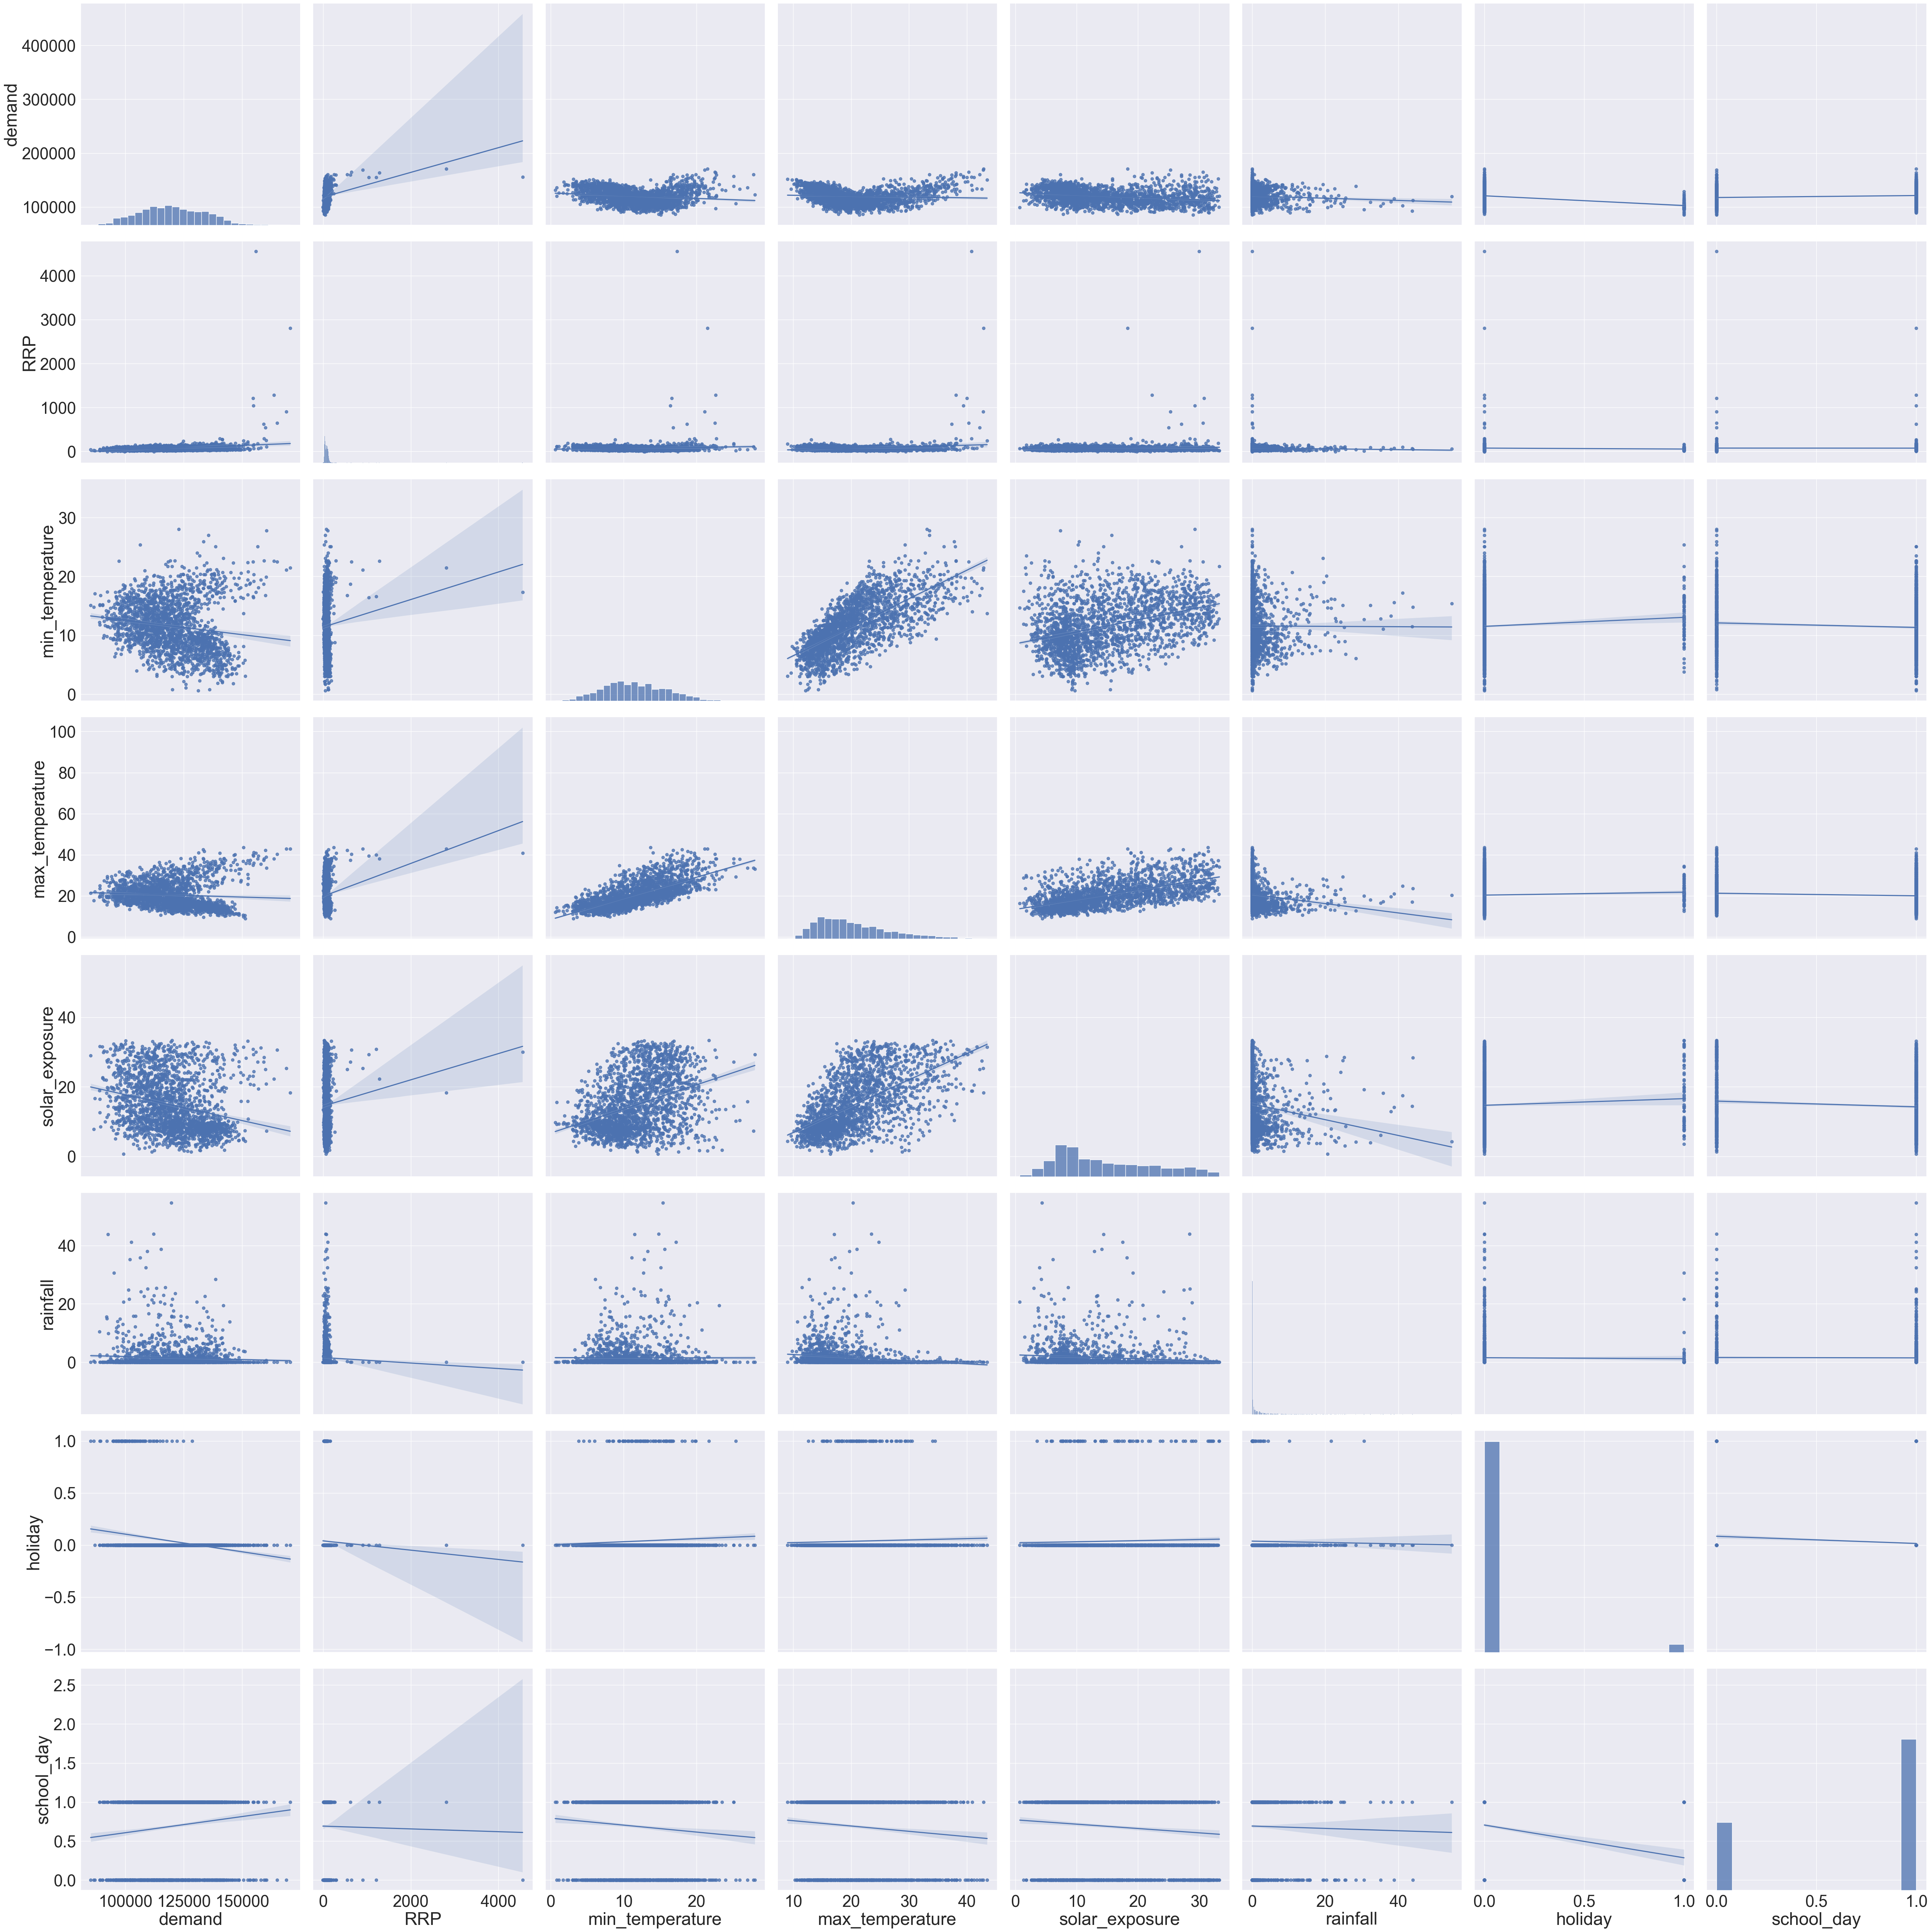

In [5]:
plot_df = df[['demand',
                'RRP',
                'min_temperature',
                'max_temperature',
                'solar_exposure',
                'rainfall',
                'holiday',
                'school_day']]
sns.set(font_scale=3)
sns.pairplot(plot_df, kind='reg', height=7)


Scale the data into standard deviation

In [5]:
scaled_df=MinMaxScaler().fit_transform(df[['demand',
                                            'RRP',
                                            'min_temperature',
                                            'max_temperature',
                                            'solar_exposure',
                                            'rainfall']])
scaled_df=pd.DataFrame(scaled_df, columns=['demand',
                                           'RRP',
                                            'min_temperature',
                                            'max_temperature',
                                            'solar_exposure',
                                            'rainfall'])
scaled_df['holiday'] = df['holiday']
scaled_df['school_day'] = df['school_day']
scaled_df[1491:1500]

demand       RRP  min_temperature  max_temperature  solar_exposure  \
1491  0.294331  0.024935         0.605839         0.362319        0.831288   
1492  0.225906  0.027166         0.437956         0.440580        0.861963   
1493  0.463475  0.054224         0.525547         0.736232        0.822086   
1494  0.563272  0.042363         0.675182         0.846377        0.779141   
1495  0.398256  0.025512         0.708029         0.397101        0.263804   
1496  0.404487  0.021682         0.624088         0.518841        0.426380   
1497  0.647543  0.032823         0.653285         0.744928        0.677914   
1498  0.660350  0.033752         0.733577         0.559420        0.748466   
1499  0.376734  0.025007         0.638686         0.408696        0.625767   

      rainfall  holiday  school_day  
1491  0.120879        0           1  
1492  0.000000        0           1  
1493  0.000000        0           1  
1494  0.000000        0           1  
1495  0.000000        0           1  
1496  0.000000        0           1  
1497  0.000000        0           1  
1498  0.201465        0           1  
1499  0.000000        0           1

Create function to convert the dataframe into the Train and Test set

In [43]:
def convert_to_X_y(dataframe, window, forecasting_time):
    dataframe = dataframe.to_numpy()
    X = []
    y = []
    for i in range (window, len(dataframe) - forecasting_time + 1):
        X.append(dataframe[i - window:i, 0: dataframe.shape[1]])
        y.append(dataframe[i+forecasting_time - 1: i+ forecasting_time, 0])
    return np.array(X), np.array(y)

Convert the dataframe

In [44]:
window_size = 7
forecasting_time = 1
X, y = convert_to_X_y(scaled_df, window_size, forecasting_time)
X.shape, y.shape

((2099, 7, 8), (2099, 1))

Train test split

In [45]:
X_train, y_train = X[:1461], y[:1461]
X_test, y_test = X[1461:2099], y[1461:2099]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1461, 7, 8), (1461, 1), (638, 7, 8), (638, 1))

In [47]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
 
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences= True))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dense(y.shape[1], activation = 'linear'))

lstm_model.summary()
cp = ModelCheckpoint('lstm_model/', save_best_only=True)
lstm_model.compile(loss = 'mse',
                    optimizer=Adam(learning_rate=0.001),
                    metrics = [RootMeanSquaredError()])
lstm_model.fit(X_train, y_train, epochs=50, batch_size= 10, validation_data=(X_test, y_test), verbose= 1, callbacks = [cp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31137 (121.63 KB)
Trainable params: 31137 (121.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
124/147 [========================>.....] - ETA: 0s - loss: 0.0341 - root_mean_squared_error: 0.1847INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 3s 12ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 2/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408
Epoch 3/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0182 - root_mean_squared_error: 0.1351 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 4/50
134/147 [==========================>...] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.1320INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1317 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1321
Epoch 5/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 6/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.1260INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 7/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1224INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 8/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1403
Epoch 9/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 10/50
128/147 [=========================>....] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1111INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1250
Epoch 11/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1101INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 12/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 13/50
132/147 [=========================>....] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1065INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 14/50
134/147 [==========================>...] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1009INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 15/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1116
Epoch 16/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 17/50
133/147 [==========================>...] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0917INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 10ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 18/50
130/147 [=========================>....] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0910INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 19/50
129/147 [=========================>....] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0862INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 20/50
129/147 [=========================>....] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0866INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 21/50
124/147 [========================>.....] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0854INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 22/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009
Epoch 23/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 24/50
129/147 [=========================>....] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0855INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 25/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 26/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997
Epoch 27/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 28/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 29/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0097 - val_root_m

INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 31/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 32/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 33/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 34/50
147/147 [==============================] - 0s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 35/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0102 - val_root_m

INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 2s 11ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 41/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0061 - root_mean_squared_error: 0.0784 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 42/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 43/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 44/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 45/50
127/147 [========================>.....] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0776INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 46/50
125/147 [========================>.....] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0799INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


147/147 [==============================] - 1s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 47/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 48/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 49/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 50/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008


In [48]:
from keras.models import load_model
best_LSTM = load_model('lstm_model/')

20/20 [==============================] - 0s 1ms/step


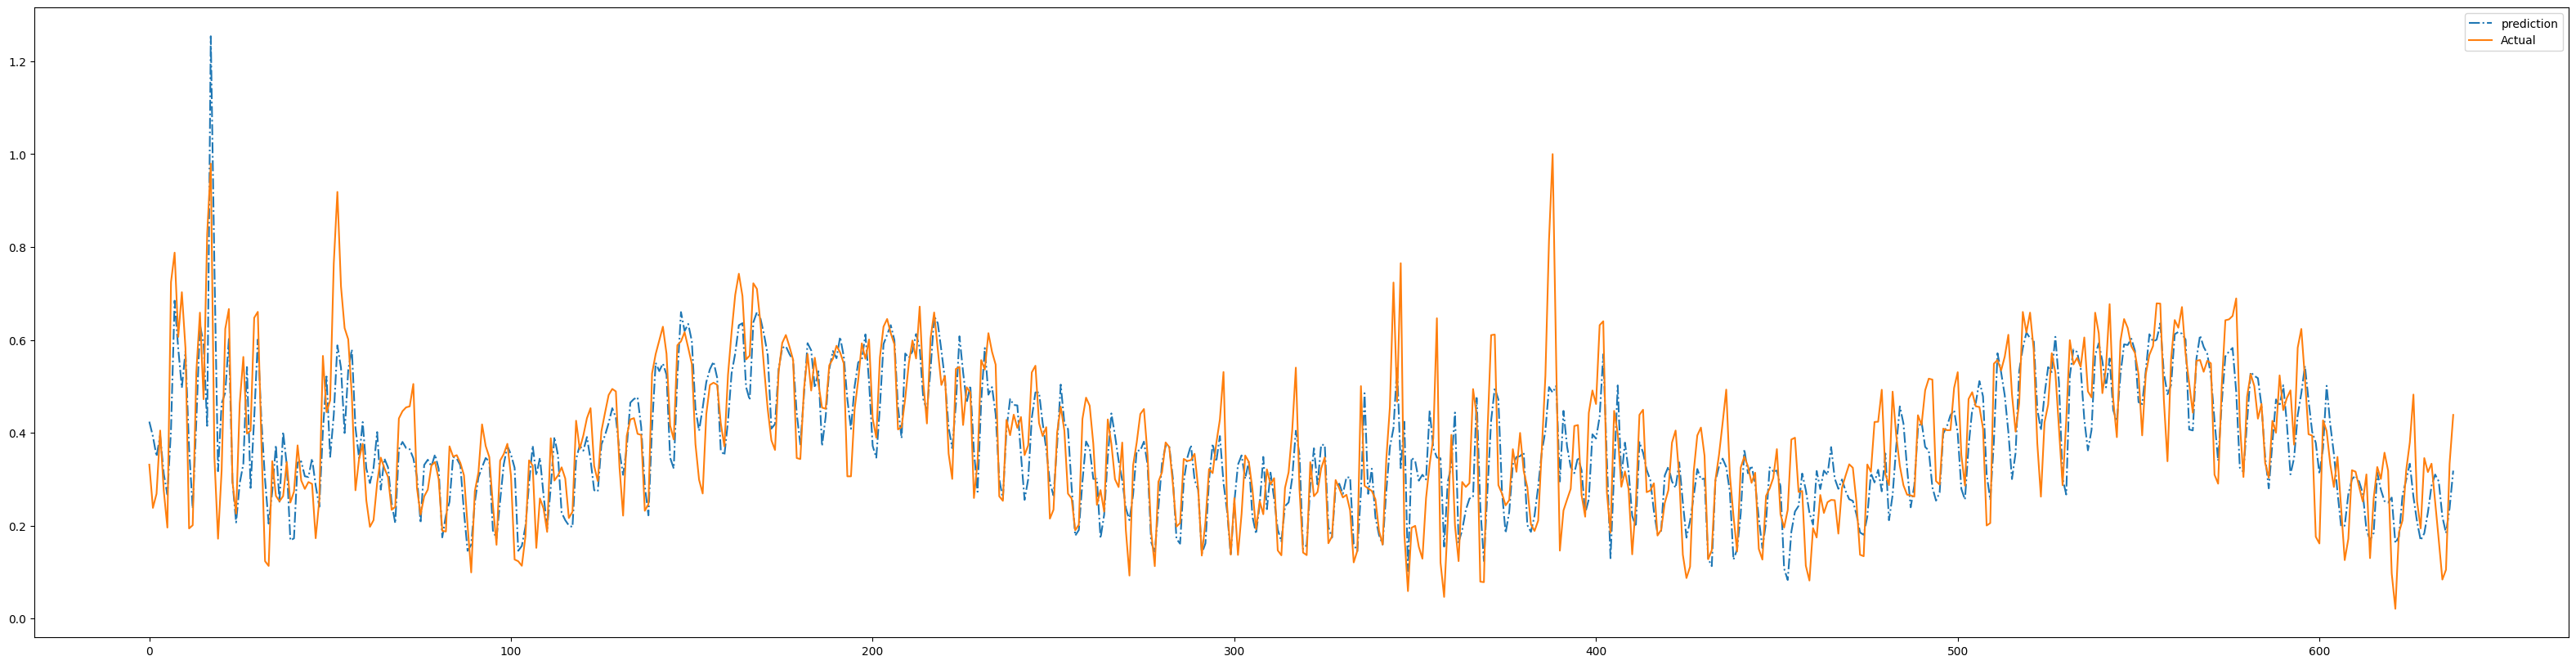

Execution time: 0.1966381072998047 seconds
Mean_squared_error: 0.009271947370888472
Mean_absolute_error: 0.07106600840916688
Root mean squared error: 0.09629095165636527


In [49]:
lstm_start_time = time.time()
test_prediction = best_LSTM.predict(X_test)
lstm_end_time = time.time()
# train_results = pd.DataFrame(data={'Train_prediction': train_prediction, 'Actual result': y_train})
# train_results
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Execution time:", lstm_end_time - lstm_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

### Random Forest

In [54]:
train = scaled_df.loc[scaled_df.index < 1461]
test = scaled_df.loc[scaled_df.index >= 1461]
print(train)
print(test)
x_train = train.drop(labels='demand', axis=1)
y_train = train['demand']
x_test = test.drop(labels='demand', axis=1)
y_test = test['demand']
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

        demand       RRP  min_temperature  max_temperature  solar_exposure  \
0     0.169948  0.006960         0.463504         0.518841        0.702454   
1     0.520242  0.008608         0.540146         0.863768        0.800613   
2     0.668613  0.008921         0.708029         0.846377        0.791411   
3     0.224830  0.006823         0.572993         0.359420        0.751534   
4     0.386139  0.007200         0.525547         0.376812        0.920245   
...        ...       ...              ...              ...             ...   
1456  0.521915  0.023791         0.569343         0.823188        0.877301   
1457  0.569627  0.027995         0.777372         0.794203        0.564417   
1458  0.271107  0.021467         0.744526         0.431884        0.153374   
1459  0.169701  0.019809         0.642336         0.397101        0.282209   
1460  0.213741  0.019969         0.609489         0.420290        0.938650   

      rainfall  holiday  school_day  
0     0.000000        1  

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {
    "n_estimators": np.arange(100, 1500, 100),
    "max_depth": np.arange(6, 20, 1),
    "max_leaf_nodes": np.arange(12, 20, 1),
#    'max_features': ['sqrt', 'log2', None],
}

rdms = RandomizedSearchCV(rf_model,
                          param_grid,
                          scoring='neg_mean_squared_error',
                          verbose = 2,
                          cv=8,
                          #random_state=42,
                          n_iter=20)
rdms.fit(x_train, y_train)
print(rdms.best_score_)
print(rdms.best_params_)
print(rdms.best_estimator_)

Fitting 8 folds for each of 20 candidates, totalling 160 fits
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=15, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=13, max_leaf_nodes=13, n_estimators=300; total time=   0.1s
[CV] END ..max_depth=13, max_leaf_nodes=13, n_estimators=300; total time=   0.1s
[CV] END ..max_depth=13, max_leaf_nodes=13, n_estimators=300; total time=   0.1s
[CV] END ..max_depth=13, max_leaf_nodes=13, n_e

In [53]:
# {'n_estimators': 1100, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 11}
# {'n_estimators': 400, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 19}
# {'n_estimators': 500, 'max_leaf_nodes': 18, 'max_features': None, 'max_depth': 6}
# {'n_estimators': 700, 'max_leaf_nodes': 12, 'max_features': None, 'max_depth': 15}
# {'n_estimators': 100, 'max_leaf_nodes': 17, 'max_features': None, 'max_depth': 6}
# {'n_estimators': 800, 'max_leaf_nodes': 19, 'max_depth': 11}
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}
# {'n_estimators': 700, 'max_leaf_nodes': 18, 'max_depth': 7}
# -0.008783526035931919
# {'n_estimators': 300, 'max_leaf_nodes': 19, 'max_depth': 14}
# -0.008521678999174397
# {'n_estimators': 600, 'max_leaf_nodes': 16, 'max_depth': 9}
# -0.009946187741837993
# {'n_estimators': 300, 'max_leaf_nodes': 17, 'max_depth': 14}
# -0.009344037853001887
# {'n_estimators': 1200, 'max_leaf_nodes': 19, 'max_depth': 19}
# -0.008496487012060117
# {'n_estimators': 800, 'max_leaf_nodes': 18, 'max_depth': 11}
# -0.008878021055771953
# {'n_estimators': 600, 'max_leaf_nodes': 16, 'max_depth': 6}
# -0.009957689230692074
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 9}
# -0.008515829481855386
# {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}
# -0.008494167941168432

In [8]:
tune_result = "\n Best Hyper Parameters: ", rdms.best_params_,"\n", "Best estimator: ", rdms.best_estimator_,"\n"
print (tune_result)

##('\n Best Hyper Parameters: ', {'n_estimators': 1000, 'max_leaf_nodes': 19, 'max_depth': 8}, '\n', 'Best estimator: ', RandomForestRegressor(max_depth=8, max_leaf_nodes=19, n_estimators=1000,
##                      n_jobs=-1), '\n')

('\n Best Hyper Parameters: ', {'n_estimators': 1100, 'max_leaf_nodes': 19, 'max_depth': 18}, '\n', 'Best estimator: ', RandomForestRegressor(max_depth=18, max_leaf_nodes=19, n_estimators=1100,
                      n_jobs=-1), '\n')


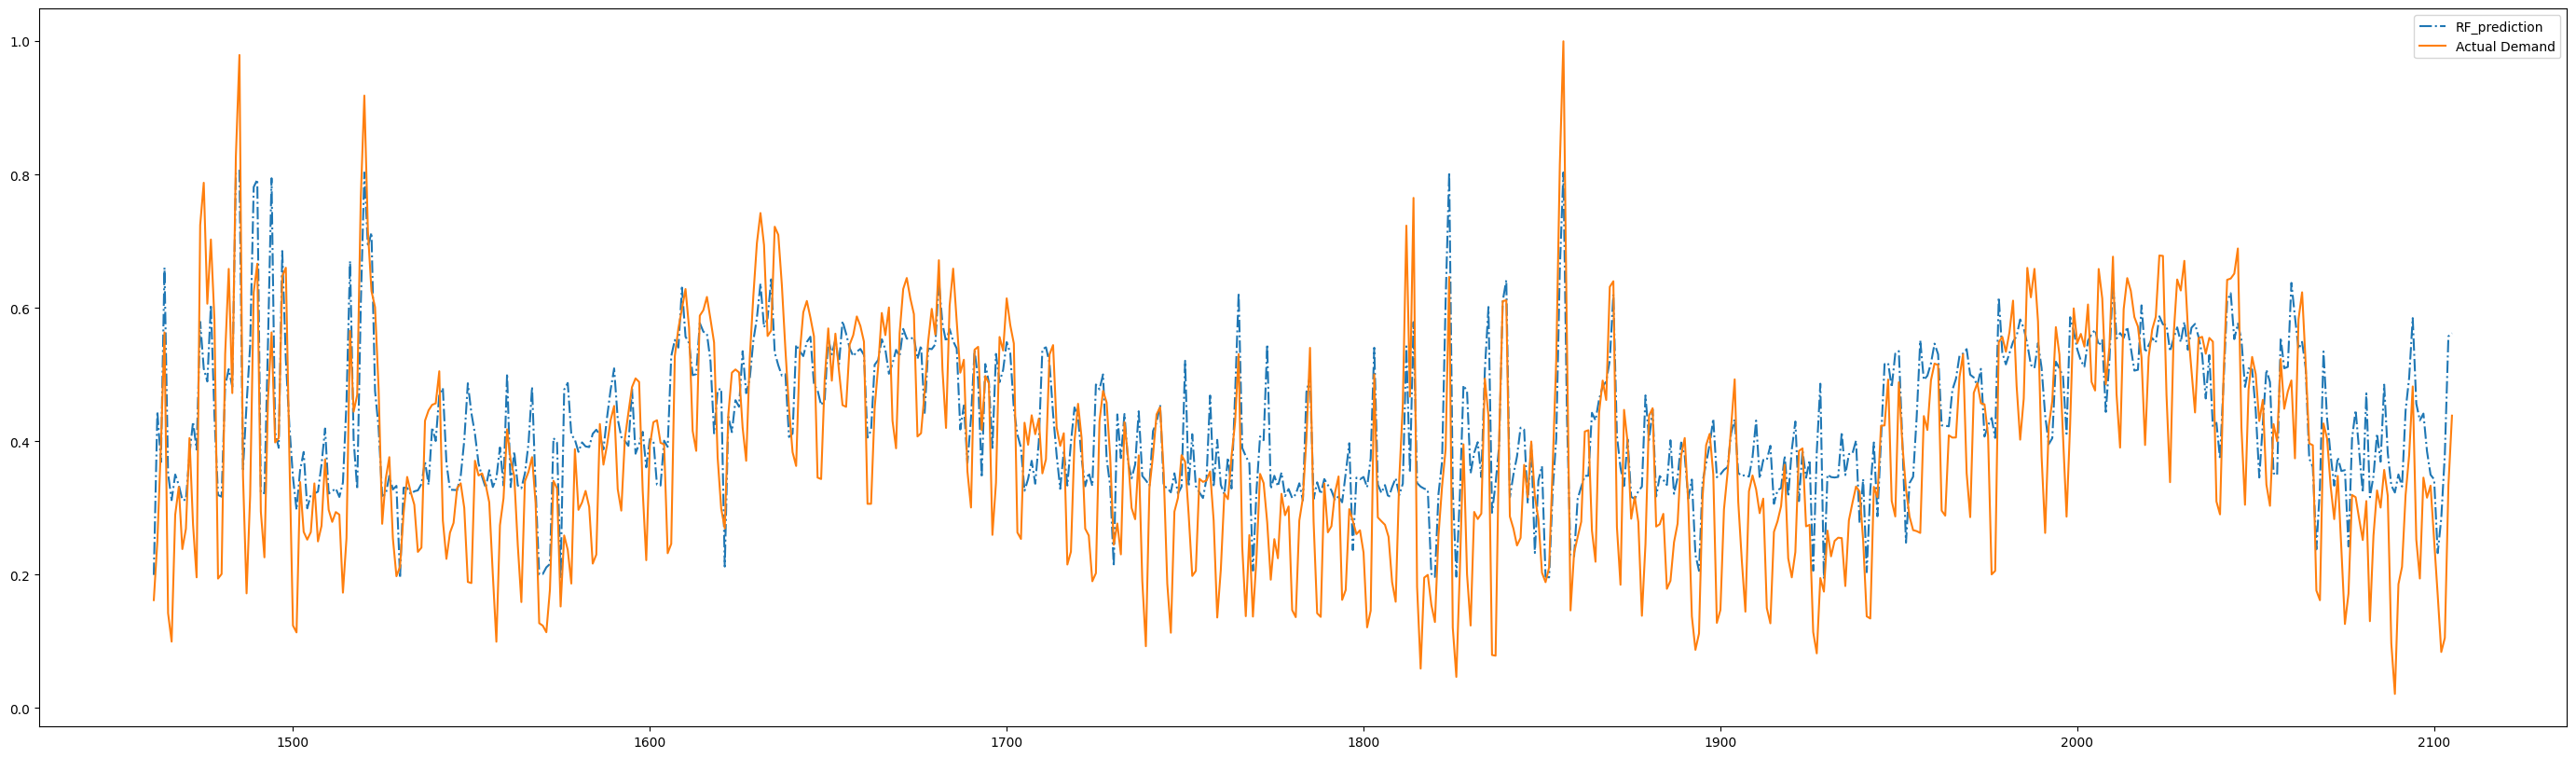

Execution time: 0.07892775535583496 seconds
Mean_squared_error: 0.0124964640090791
Mean_absolute_error: 0.08830430479441989
Root mean squared error: 0.11178758432437433


(1461    0.199475
 1462    0.444817
 1463    0.368866
 1464    0.660455
 1465    0.351283
           ...   
 2101    0.232227
 2102    0.284714
 2103    0.380778
 2104    0.557477
 2105    0.562054
 Length: 645, dtype: float64,
 1461    0.161743
 1462    0.249841
 1463    0.393822
 1464    0.563282
 1465    0.142222
           ...   
 2101    0.169373
 2102    0.083949
 2103    0.105040
 2104    0.333285
 2105    0.438446
 Name: demand, Length: 645, dtype: float64)

In [9]:
rf_tuned = rdms.best_estimator_
rf_start_time = time.time()
rf_tuned_pred = rf_tuned.predict(x_test)
rf_end_time = time.time()
rf_tuned_pred = pd.Series(rf_tuned_pred, index=y_test.index)
plt.rcParams["figure.figsize"] = (35,10)
plt.plot(rf_tuned_pred ,label = "RF_prediction", linestyle = 'dashdot')
plt.plot(y_test, label = 'Actual Demand')#, linestyle = 'dashdot')
plt.legend(loc = 'upper right')
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Execution time:", rf_end_time - rf_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, rf_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, rf_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, rf_tuned_pred)))
rf_tuned_pred, y_test

Previous best tune findings with 10-fold 10 candidates

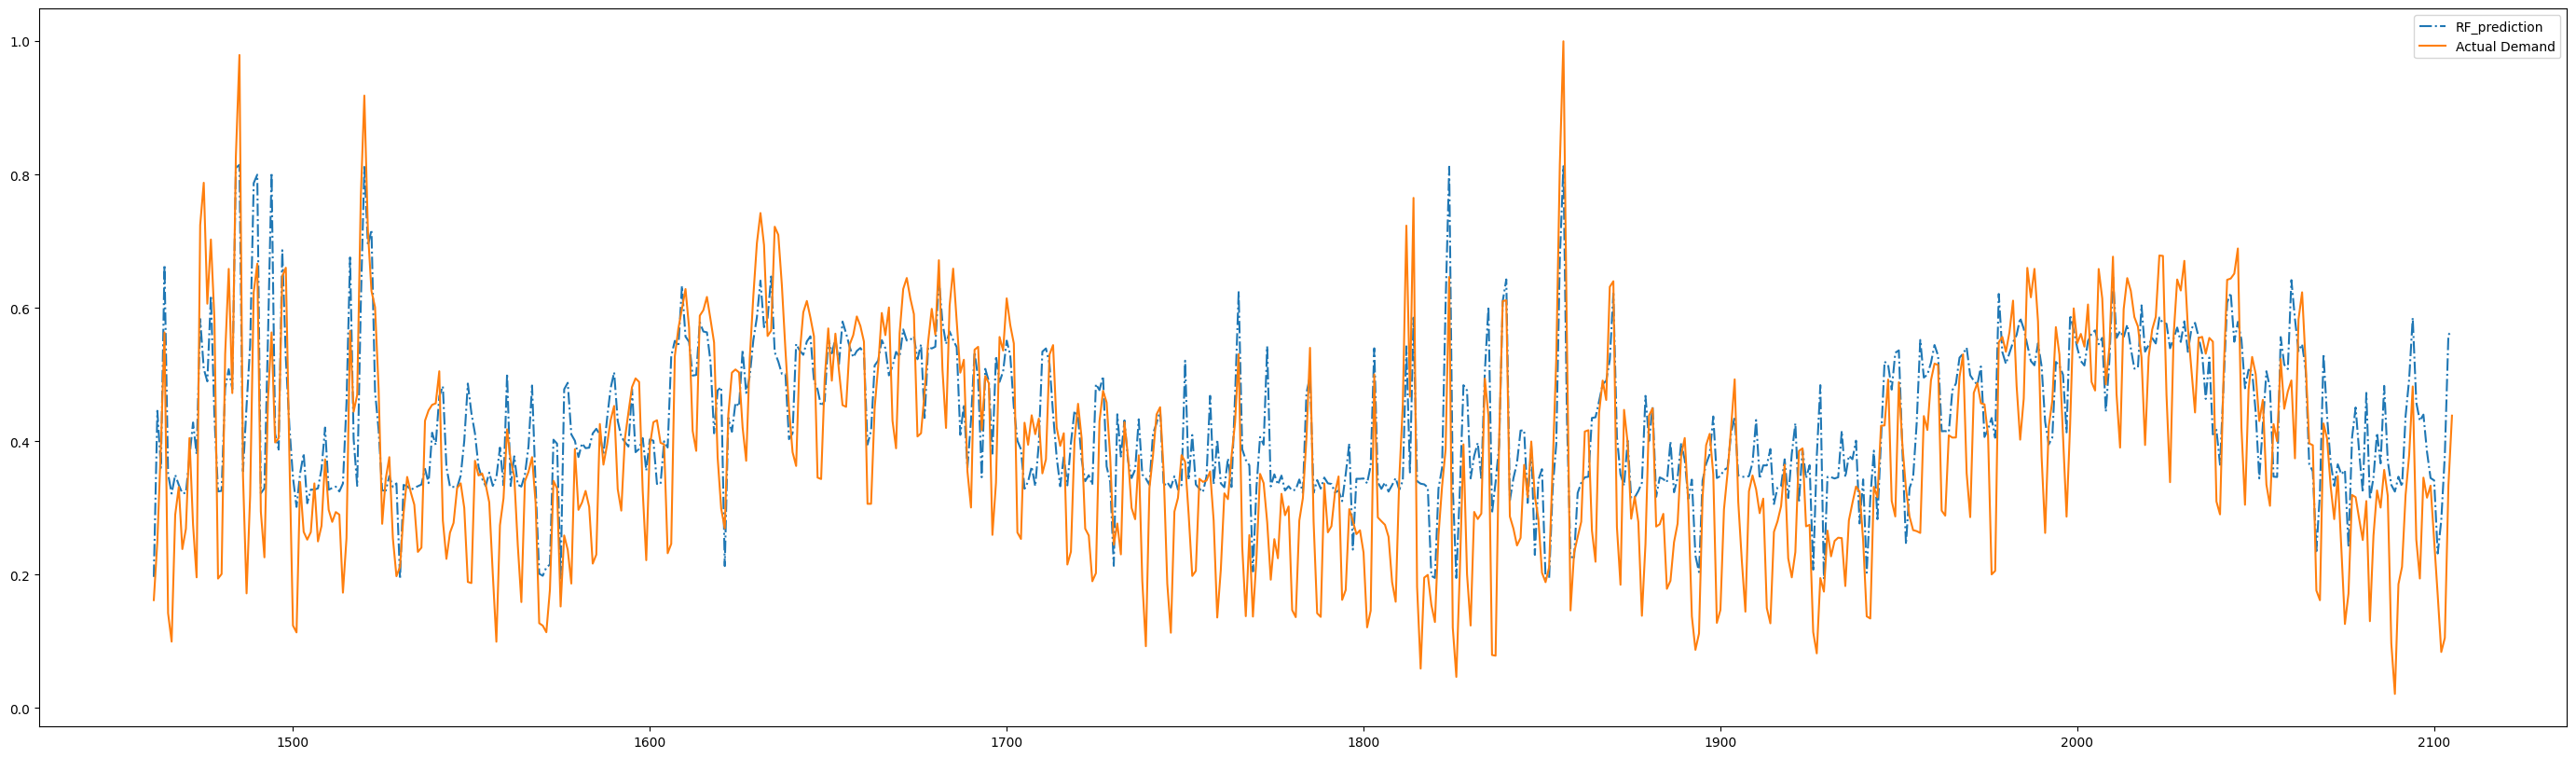

Execution time: 0.07973337173461914 seconds
Mean_squared_error: 0.012440056798539786
Mean_absolute_error: 0.08806586825372659
Root mean squared error: 0.11153500257112019


(1461    0.196523
 1462    0.445714
 1463    0.360099
 1464    0.664332
 1465    0.350927
           ...   
 2101    0.231648
 2102    0.281631
 2103    0.379800
 2104    0.559881
 2105    0.565149
 Length: 645, dtype: float64,
 1461    0.161743
 1462    0.249841
 1463    0.393822
 1464    0.563282
 1465    0.142222
           ...   
 2101    0.169373
 2102    0.083949
 2103    0.105040
 2104    0.333285
 2105    0.438446
 Name: demand, Length: 645, dtype: float64)

In [36]:
rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_leaf_nodes=19, max_depth=8)
rf_model.fit(x_train, y_train)
rf_start_time = time.time()
rf_tuned_pred = rf_model.predict(x_test)
rf_end_time = time.time()
rf_tuned_pred = pd.Series(rf_tuned_pred, index=y_test.index)
plt.rcParams["figure.figsize"] = (35,10)
plt.plot(rf_tuned_pred ,label = "RF_prediction", linestyle = 'dashdot')
plt.plot(y_test, label = 'Actual Demand')#, linestyle = 'dashdot')
plt.legend(loc = 'upper right')
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Execution time:", rf_end_time - rf_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, rf_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, rf_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, rf_tuned_pred)))
rf_tuned_pred, y_test

### SARIMA

In [18]:
fileName = 'complete_dataset.csv'
df = pd.read_csv(fileName, index_col='date', parse_dates=True).asfreq("D")
df.head()

demand        RRP  demand_pos_RRP  RRP_positive  \
date                                                              
2015-01-01   99635.030  25.633696       97319.240     26.415953   
2015-01-02  129606.010  33.138988      121082.015     38.837661   
2015-01-03  142300.540  34.564855      142300.540     34.564855   
2015-01-04  104330.715  25.005560      104330.715     25.005560   
2015-01-05  118132.200  26.724176      118132.200     26.724176   

            demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
date                                                                         
2015-01-01        2315.790     -7.240000         0.020833             13.3   
2015-01-02        8523.995    -47.809777         0.062500             15.4   
2015-01-03           0.000      0.000000         0.000000             20.0   
2015-01-04           0.000      0.000000         0.000000             16.3   
2015-01-05           0.000      0.000000         0.000000             15.0   

            max_temperature  solar_exposure  rainfall school_day holiday  
date                                                                      
2015-01-01             26.9            23.6       0.0          N       Y  
2015-01-02             38.8            26.8       0.0          N       N  
2015-01-03             38.2            26.5       0.0          N       N  
2015-01-04             21.4            25.2       4.2          N       N  
2015-01-05             22.0            30.7       0.0          N       N

<Axes: xlabel='date'>

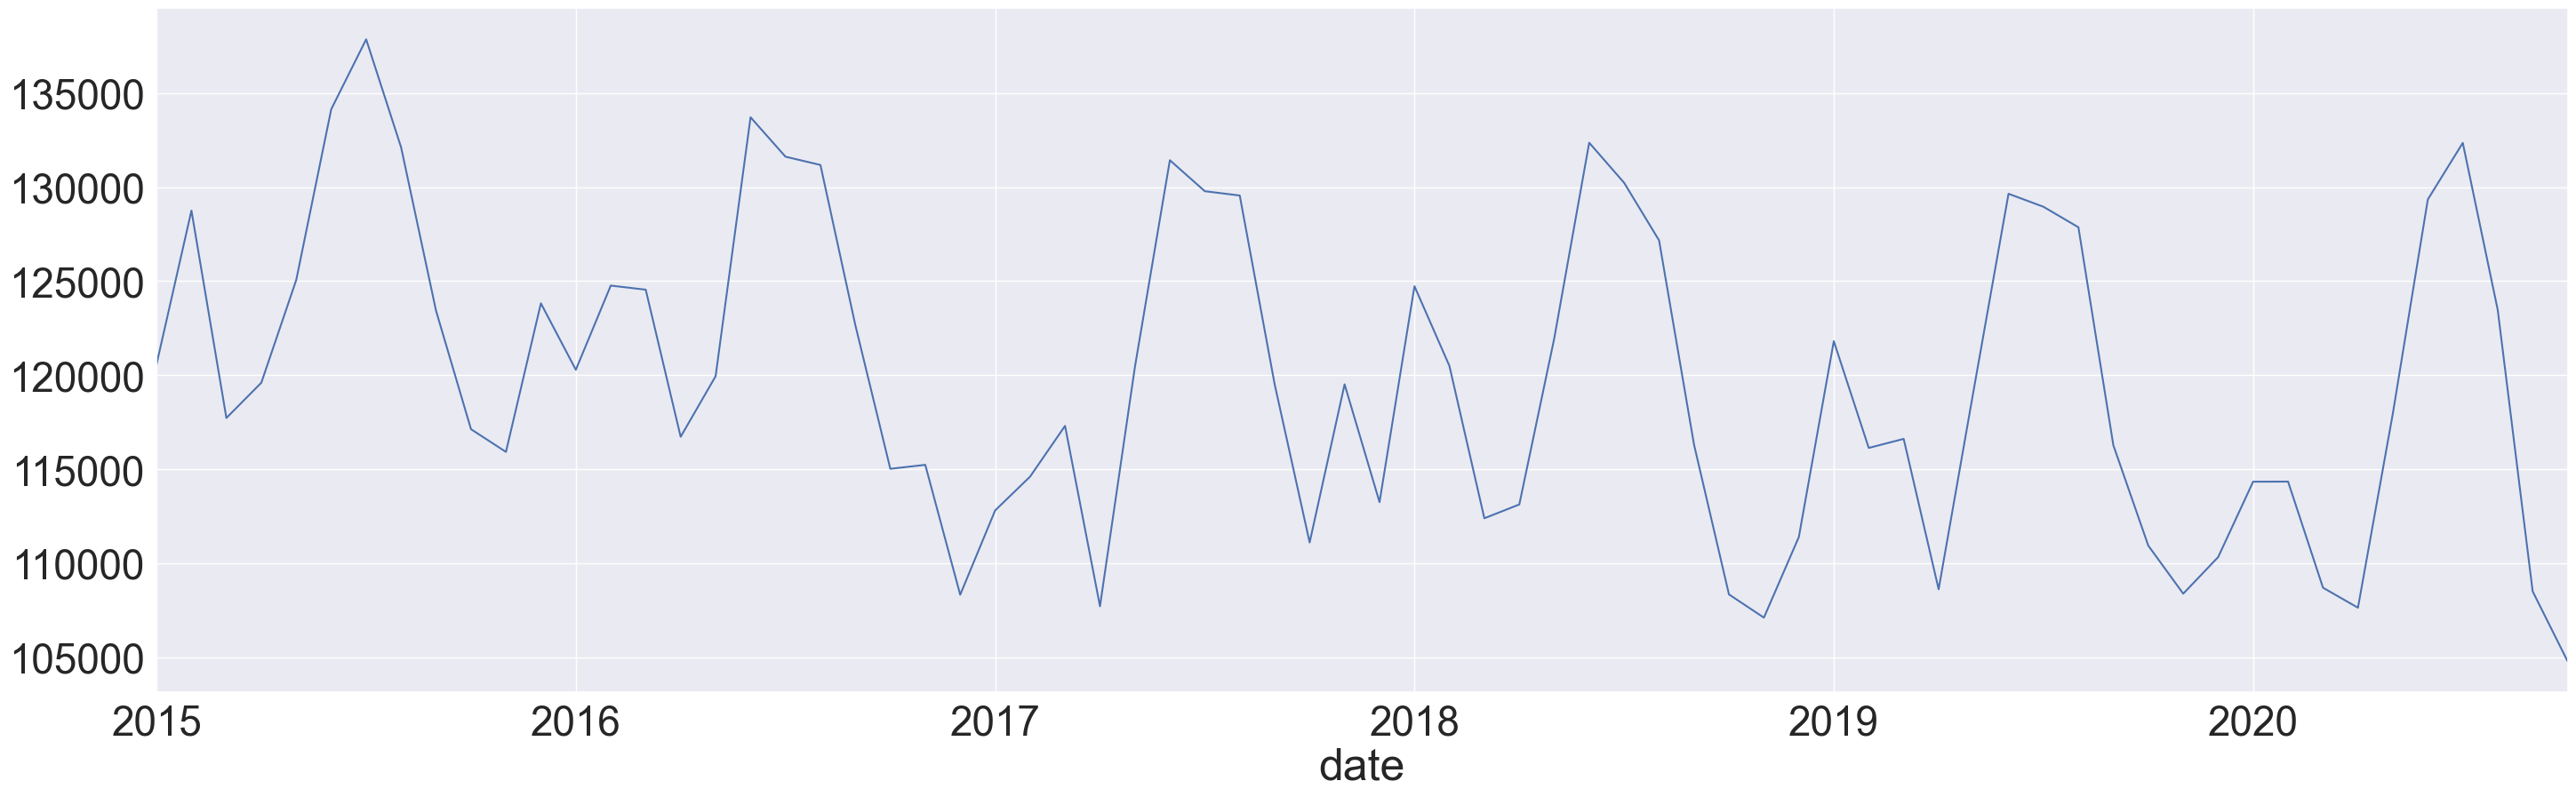

In [19]:
monthly_df = df['demand'].resample('M').mean()
monthly_df.plot()

In [20]:
monthly_df.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
      

In [21]:
train = monthly_df.loc[monthly_df.index.get_level_values(0) <= '2018-12-31']
test = monthly_df[monthly_df.index.get_level_values(0) >= '2019-01-31']
train, test

(date
 2015-01-31    120576.860323
 2015-02-28    128754.107679
 2015-03-31    117730.704839
 2015-04-30    119606.603500
 2015-05-31    125072.101935
 2015-06-30    134137.917833
 2015-07-31    137856.058387
 2015-08-31    132113.753387
 2015-09-30    123427.208000
 2015-10-31    117135.675161
 2015-11-30    115927.911333
 2015-12-31    123824.128871
 2016-01-31    120292.740806
 2016-02-29    124767.840000
 2016-03-31    124549.920000
 2016-04-30    116731.018500
 2016-05-31    119950.549677
 2016-06-30    133713.506667
 2016-07-31    131618.328387
 2016-08-31    131178.282581
 2016-09-30    122656.683167
 2016-10-31    115029.608387
 2016-11-30    115241.024167
 2016-12-31    108336.597581
 2017-01-31    112818.727097
 2017-02-28    114614.890357
 2017-03-31    117311.886129
 2017-04-30    107725.249333
 2017-05-31    120448.647903
 2017-06-30    131431.604667
 2017-07-31    129783.944839
 2017-08-31    129554.926290
 2017-09-30    119511.055000
 2017-10-31    111114.919839
 2017-11

In [22]:
from pmdarima import auto_arima
search_fit = auto_arima(train,
                        trace=True,
                        m=12,
                        n_jobs=-1,
                        frequency = 30,
                        error_action='ignore')
search_fit.summary()

c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=731.452, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=724.257, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=726.506, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=726.612, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=726.870, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=725.800, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=725.806, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=727.792, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=726.346, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=725.514, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=728.164, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.875 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -360.129
Date:                  Sat, 30 Sep 2023   AIC                            724.257
Time:                          21:32:30   BIC                            727.424
Sample:                      01-31-2015   HQIC                           725.363
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1957.6819    891.513     -2.196      0.028   -3705.015    -210.349
sigma2      2.861e+07   5.83e+06      4.909      0.000    1.72e+07       4e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.93   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.03   Prob(JB):                         0.71
Heteroskedasticity (H):               1.50   Skew:                            -0.02
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model_sarima = SARIMAX(train['demand'], order())
predictions = pd.Series(search_fit.predict(len(test)))
predictions.index = test.index
predictions[-5:]

date
2020-06-30    128445.449089
2020-07-31    126314.362062
2020-08-31    123254.143836
2020-09-30    112400.240422
2020-10-31    104438.172546
Freq: M, dtype: float64

<Axes: xlabel='date'>

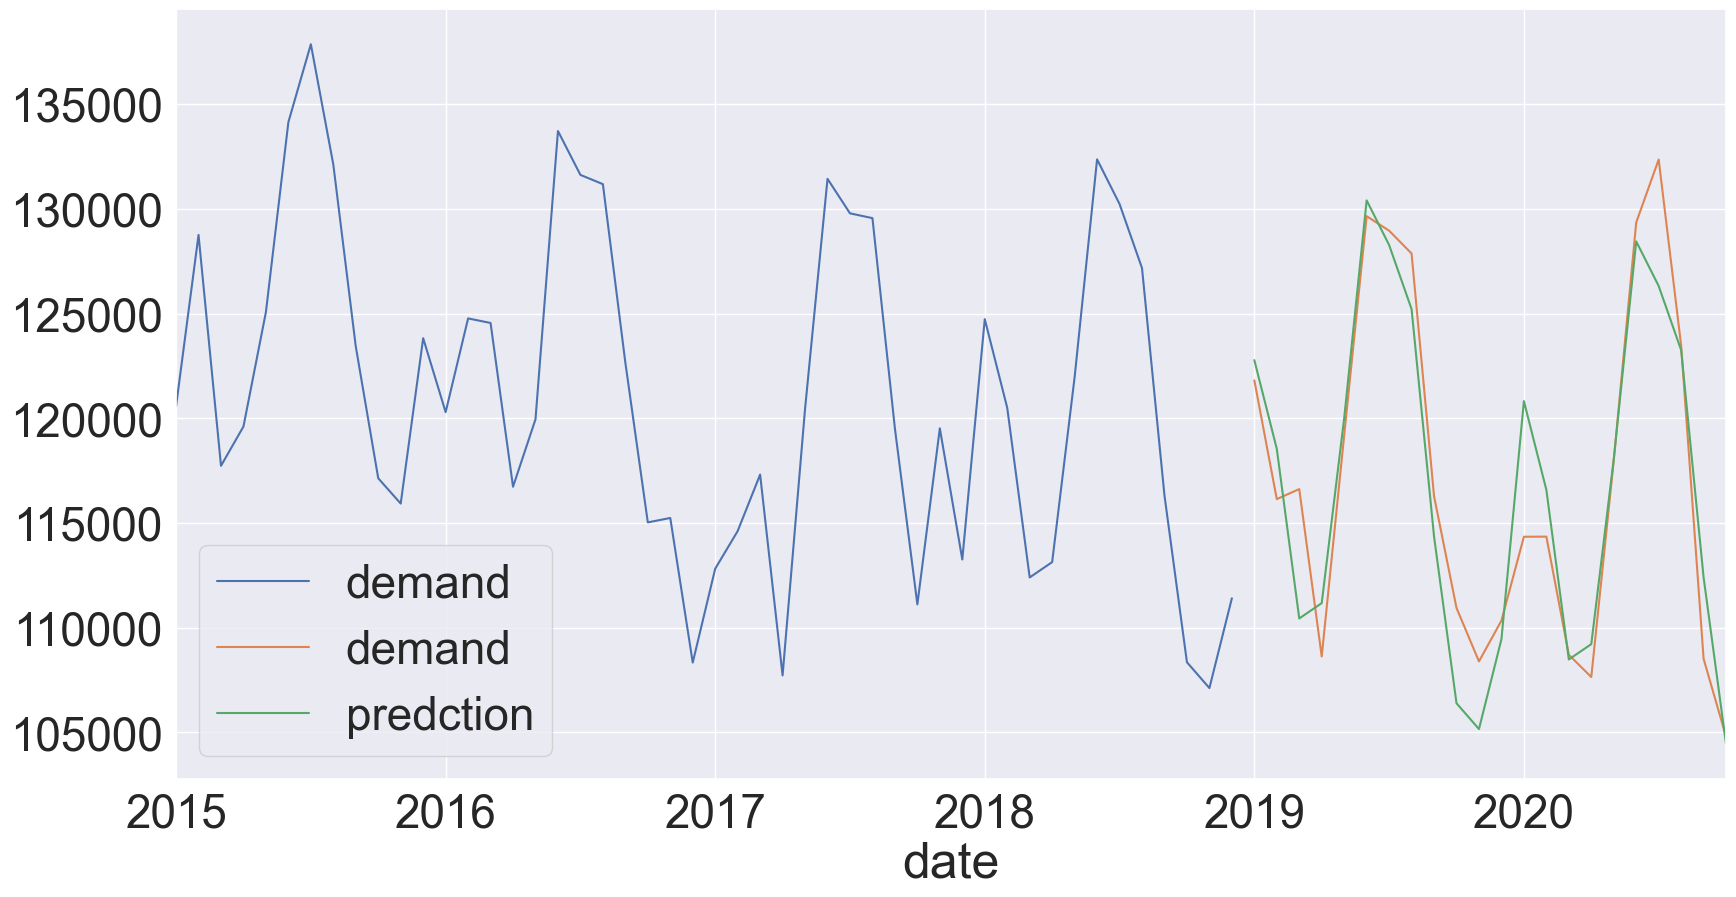

In [24]:
train.plot(figsize=(20,10), legend = True)
test.plot(figsize=(20,10), legend = True)
predictions.plot(legend = True, label = 'predction')

Text(0, 0.5, 'demand')

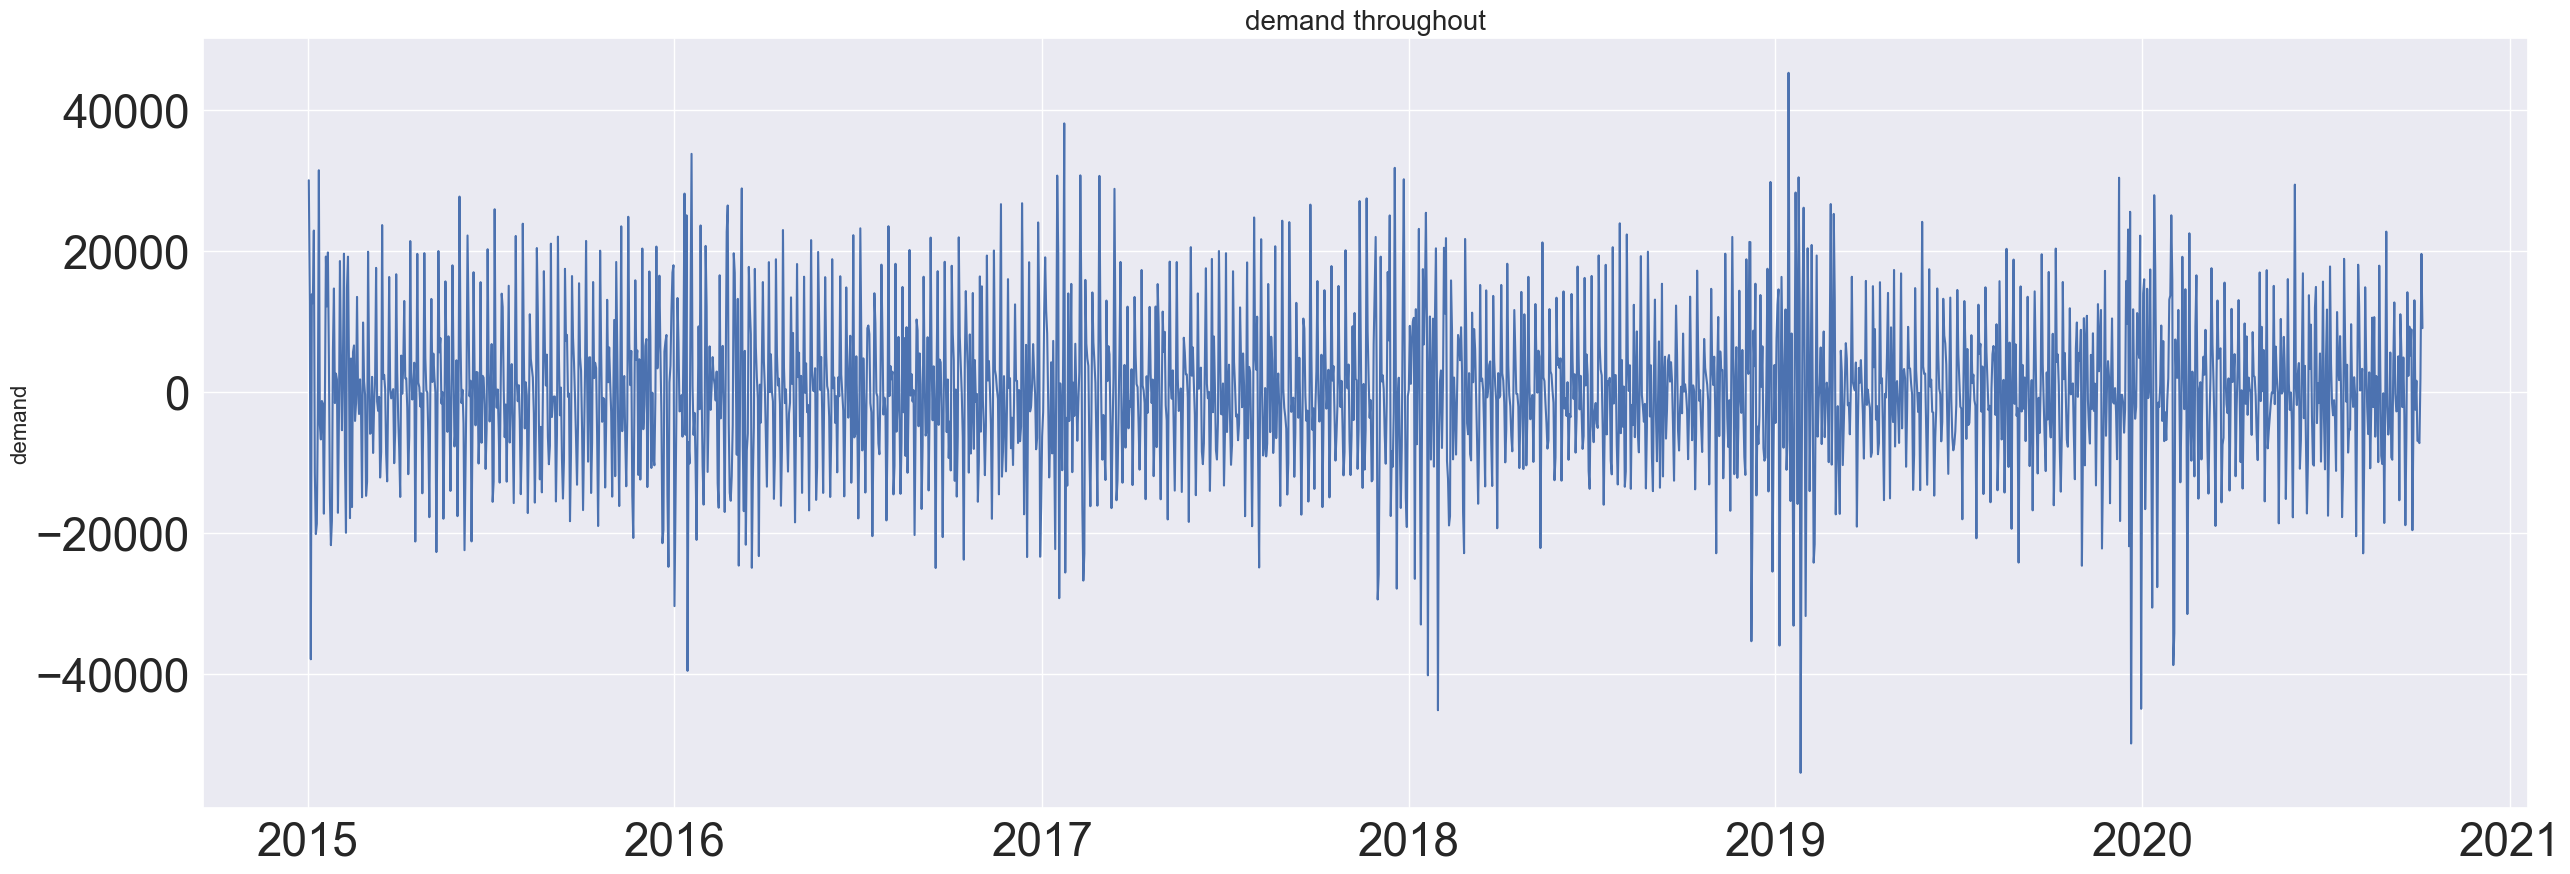

In [25]:
first_diff = df['demand'].diff()[1:]
plt.figure(figsize=(30,10))
plt.plot(first_diff)
plt.title('demand throughout', fontsize=20)
plt.ylabel('demand', fontsize=16)

ACF

[ 1.          0.06851388 -0.37427892 -0.17520923 -0.11106592 -0.21881923
  0.07621099  0.49166944  0.06155536 -0.23152074 -0.08219572 -0.08096109
 -0.21738747  0.07195055  0.46709857  0.06689513 -0.20840272 -0.09980835
 -0.09505323 -0.20029926  0.05682447  0.4787611   0.08323631 -0.20578437
 -0.11522668 -0.09206546 -0.2231981   0.06441868  0.48617632  0.0812172
 -0.22233069 -0.09565579 -0.08346485 -0.22804393]


<BarContainer object of 34 artists>

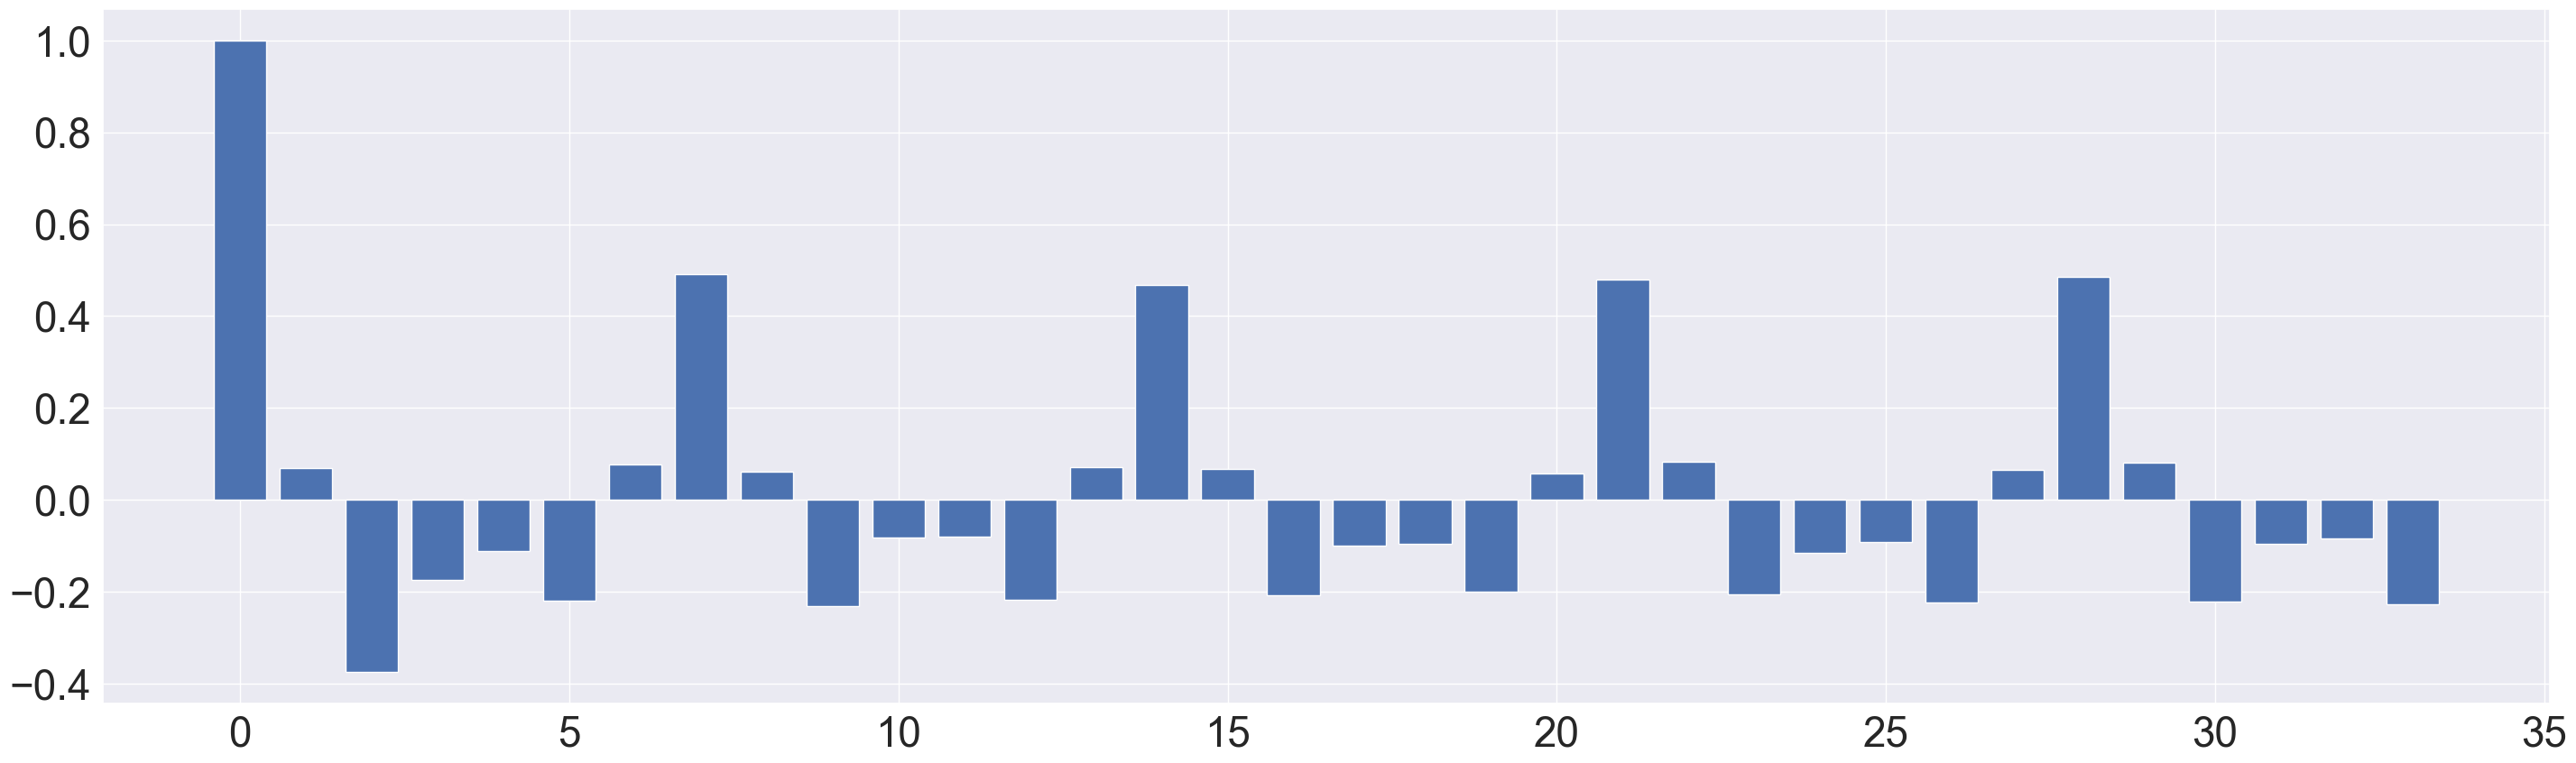

In [26]:
from statsmodels.tsa.stattools import acf, pacf
acf_vals = acf(first_diff)
print(acf_vals)
num_lags = 34
plt.bar(range(num_lags), acf_vals[:num_lags])

PACF

<BarContainer object of 34 artists>

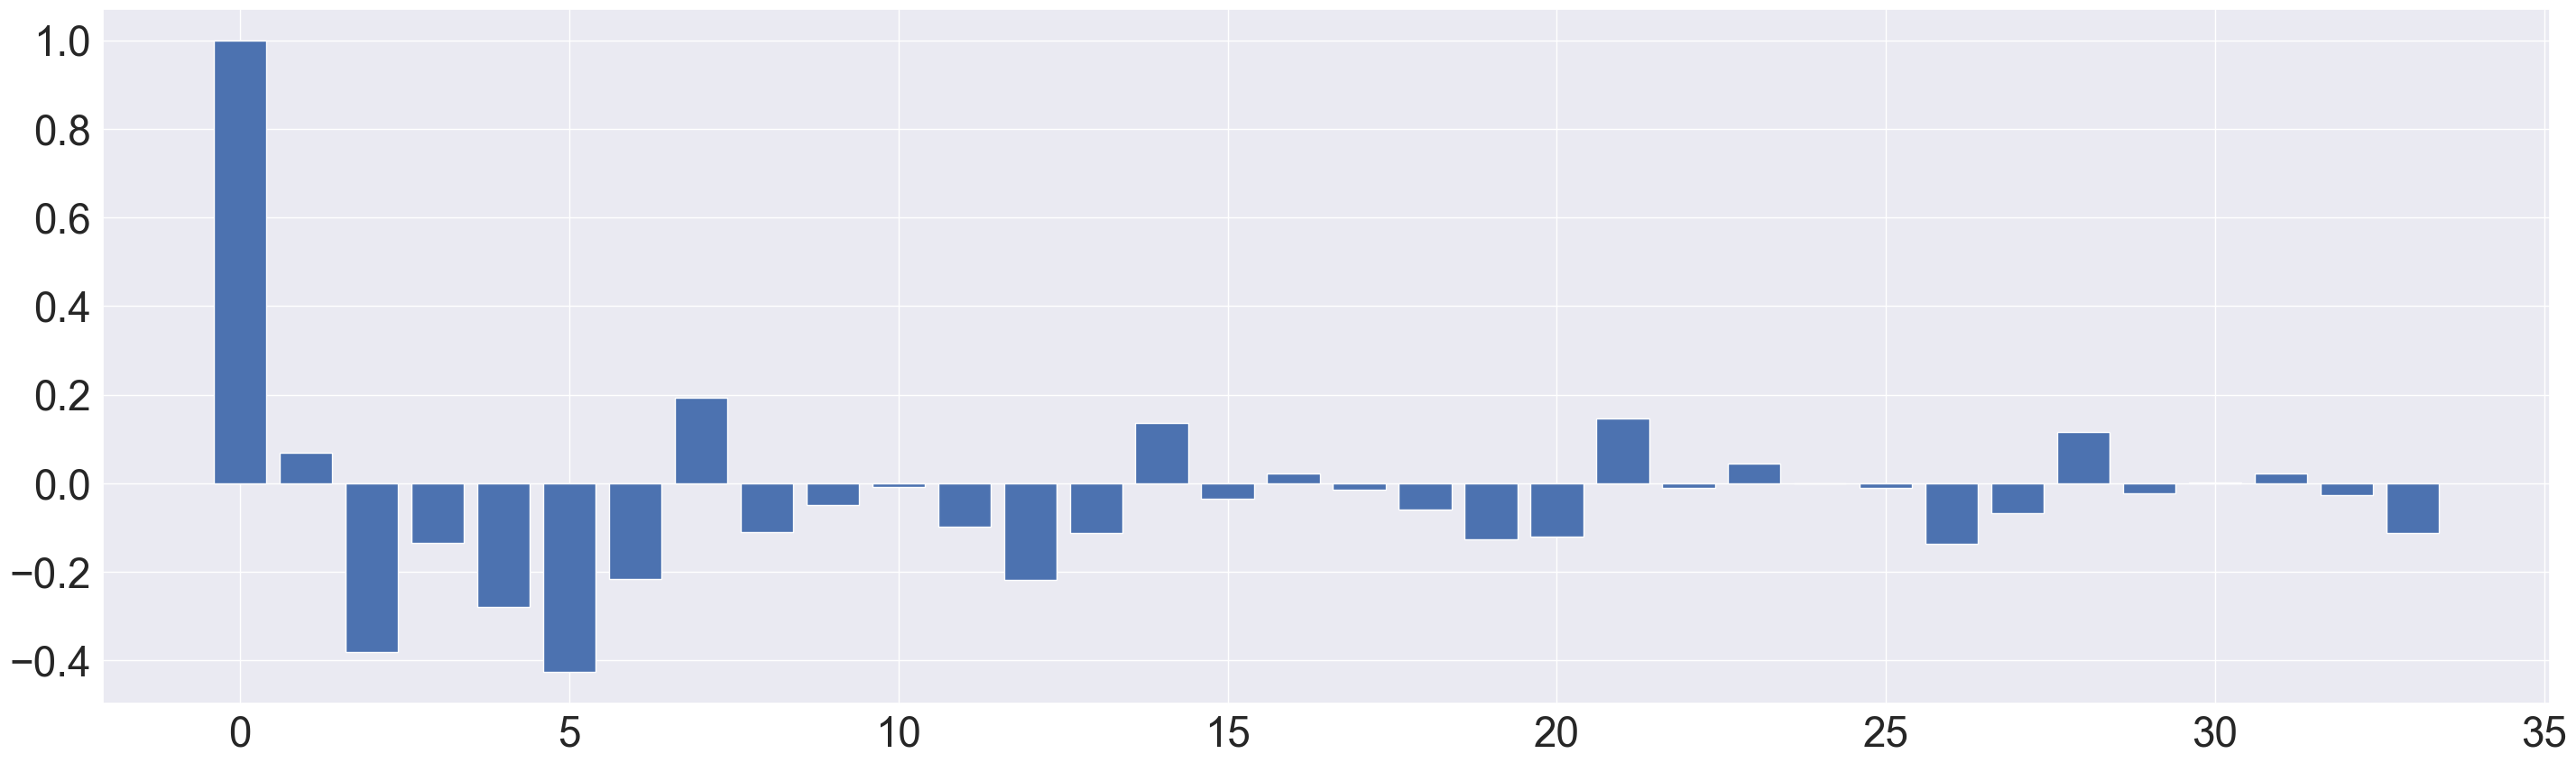

In [27]:
pacf_vals = pacf(first_diff)
num_lags = 34
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [28]:
order = (1,1,1)
seasonal_order = (1, 0, 1, 7)
model_sarima = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
model_fit = model_sarima.fit(low_memory=True)
model_fit.summary()

c:\Users\AB\ITS-Capstone\ITS-Capstone-11522-23-14\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            demand   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1556.428
Date:                           Sat, 30 Sep 2023   AIC                          -3102.856
Time:                                   21:32:31   BIC                          -3076.425
Sample:                                        0   HQIC                         -3092.996
                                          - 1461                                         
Covariance Type:                          approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6087      0.026     23.182      0.000       0.557       0.660
ma.L1         -0.9359      0.011    -87.678      0.000      -0.957      -0.915
ar.S.L7        0.9999      0.000   3574.270      0.000       0.999       1.000
ma.S.L7       -0.9853      0.012    -83.018      0.000      -1.009      -0.962
sigma2         0.0068      0.000     26.329      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                  28.24   Jarque-Bera (JB):               677.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.17
Prob(H) (two-sided):                  0.79   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: >

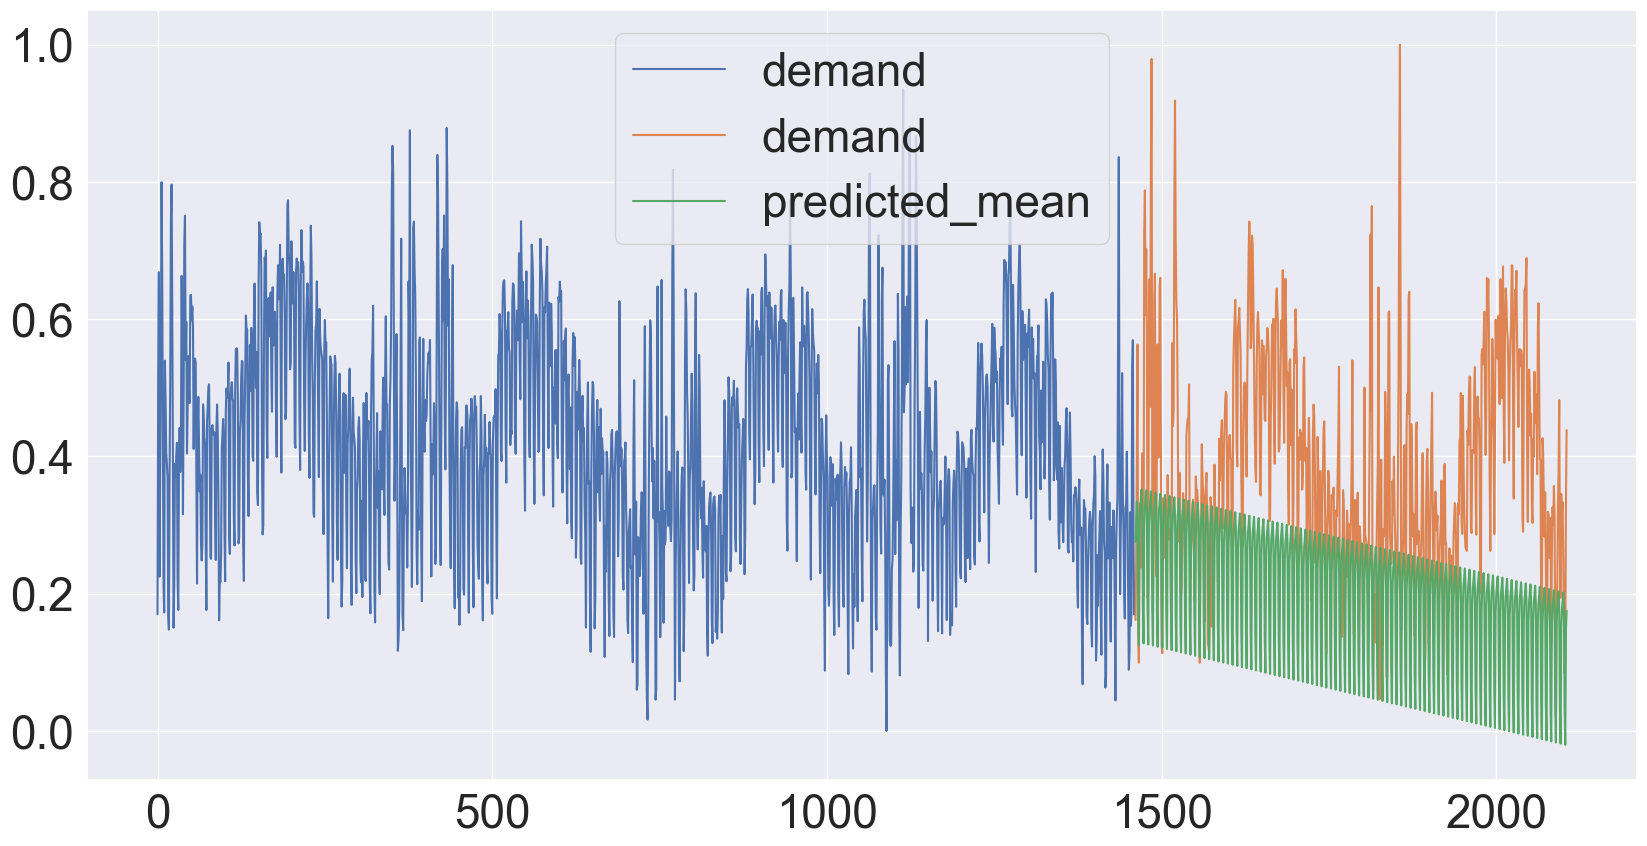

In [29]:
predictions = model_fit.forecast(len(y_test))
predictions = pd.Series(predictions, index=y_test.index)
y_train.plot(figsize=(20,10), legend = True)
y_test.plot(figsize=(20,10), legend = True)
predictions.plot(legend = True)

# XGBoost

In [59]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
xgb = XGBRegressor(n_jobs = -1, objective = 'reg:squarederror')
xgb_params = {
        'learning_rate' : [0.001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'min_child_weight': np.arange(1, 10, 1),
        "max_depth": np.arange(3, 10, 1),
        'gamma': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': np.arange(0.5, 1, 0.1),
        'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5]
}

xgb_randomSearch = RandomizedSearchCV(xgb, xgb_params, scoring='neg_mean_squared_error', verbose=1, cv=10, random_state=2, n_iter=50)
xgb_randomSearch.fit(x_train, y_train)


# rdms = RandomizedSearchCV(rf_model, param_grid, scoring='neg_mean_absolute_error', verbose = 2, cv=10, random_state=42)
# rdms.fit(x_train, y_train)
# print(rdms.best_score_)
# print(rdms.best_params_)
# print(rdms.best_estimator_)
                                        

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.01, 0.1, 0.2, 0.3, 0.4,
                                                  0.5],
                                        'learning_rate': [0.001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=2, scoring='neg_mean_squared_error', verbose=1)

-0.013401210415375694
{'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}


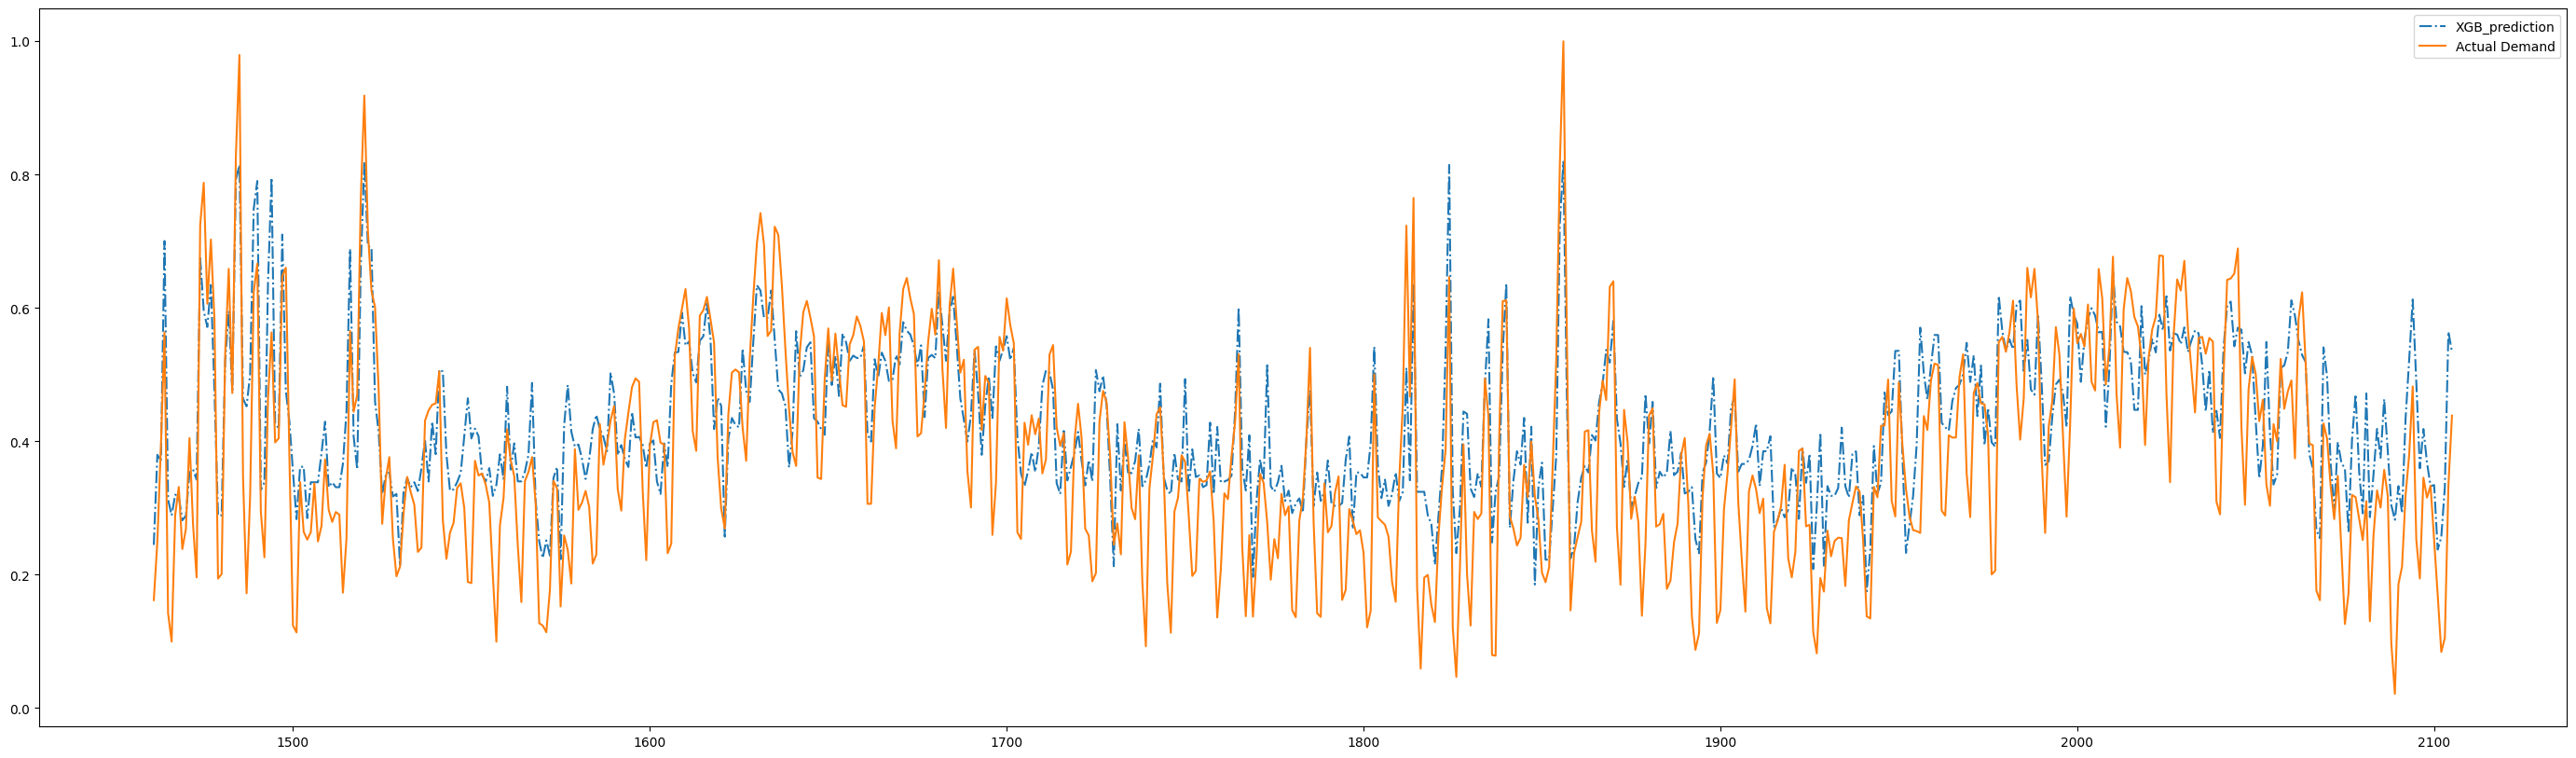

Execution time: 0.0009996891021728516 seconds
Mean_squared_error: 0.011647925354062451
Mean_absolute_error: 0.08588924459654007
Root mean squared error: 0.10792555468498853


(1461    0.244573
 1462    0.379729
 1463    0.370482
 1464    0.700417
 1465    0.312496
           ...   
 2101    0.237577
 2102    0.256113
 2103    0.331174
 2104    0.564555
 2105    0.533596
 Length: 645, dtype: float32,
 1461    0.161743
 1462    0.249841
 1463    0.393822
 1464    0.563282
 1465    0.142222
           ...   
 2101    0.169373
 2102    0.083949
 2103    0.105040
 2104    0.333285
 2105    0.438446
 Name: demand, Length: 645, dtype: float64)

In [60]:
print(xgb_randomSearch.best_score_)
print(xgb_randomSearch.best_params_)
xgb_tuned = xgb_randomSearch.best_estimator_
xgb_start_time = time.time()
xgb_tuned_pred = xgb_tuned.predict(x_test)
xgb_end_time = time.time()
xgb_tuned_pred = pd.Series(xgb_tuned_pred, index=y_test.index)
plt.rcParams["figure.figsize"] = (35,10)
plt.plot(xgb_tuned_pred ,label = "XGB_prediction", linestyle = 'dashdot')
plt.plot(y_test, label = 'Actual Demand')#, linestyle = 'dashdot')
plt.legend(loc = 'upper right')
plt.show()
print("Execution time:", xgb_end_time - xgb_start_time, "seconds")
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, xgb_tuned_pred))
print('Mean_absolute_error:', mean_absolute_error(y_test, xgb_tuned_pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, xgb_tuned_pred)))
xgb_tuned_pred, y_test

# LSTM Hyperparamter tuning

In [90]:
def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=320, step=32),
                activation='relu', input_shape=(X.shape[1], X.shape[2]),
                return_sequences=True))
    # for i in range(hp.Int('n_layers', 0, 4)):
    #     model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),
    #                    return_sequences=True))
    model.add(LSTM(hp.Int('lstm_1_units', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse',
                    optimizer=Adam(hp.Choice('learning_rate', values=[0.0001,0.001,0.01])),
                    metrics = [RootMeanSquaredError()])
    return model

In [91]:
from keras_tuner import RandomSearch, BayesianOptimization
from keras.callbacks import EarlyStopping
tuner = BayesianOptimization(
    build_lstm,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    seed=42,
    overwrite=True,
    project_name = 'lstm_tune'
)
se = EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=10,
             validation_data=(X_test, y_test),
             callbacks=[se])

Trial 10 Complete [00h 02m 55s]
val_loss: 0.009814529990156492

Best val_loss So Far: 0.009597349291046461
Total elapsed time: 00h 36m 22s


In [92]:
best_LSTM_with_tuner = tuner.get_best_models(num_models=1)[0]
best_LSTM_with_tuner.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 192)            154368    
                                                                 
 lstm_1 (LSTM)               (None, 32)                28800     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 183201 (715.63 KB)
Trainable params: 183201 (715.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model: "sequential"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  lstm (LSTM)                 (None, 7, 192)            154368    
                                                                 
#  lstm_1 (LSTM)               (None, 32)                28800     
                                                                 
#  dropout (Dropout)           (None, 32)                0         
                                                                 
#  dense (Dense)               (None, 1)                 33        
                                                                 
# =================================================================
# Total params: 183201 (715.63 KB)
# Trainable params: 183201 (715.63 KB)
# Non-trainable params: 0 (0.00 Byte)
# _________________________________________________________________
# 36m 21.9s
# Mean_squared_error: 0.009085522554987537
# Mean_absolute_error: 0.07075558800258577
# Root mean squared error: 0.09531800750638642

20/20 [==============================] - 0s 5ms/step


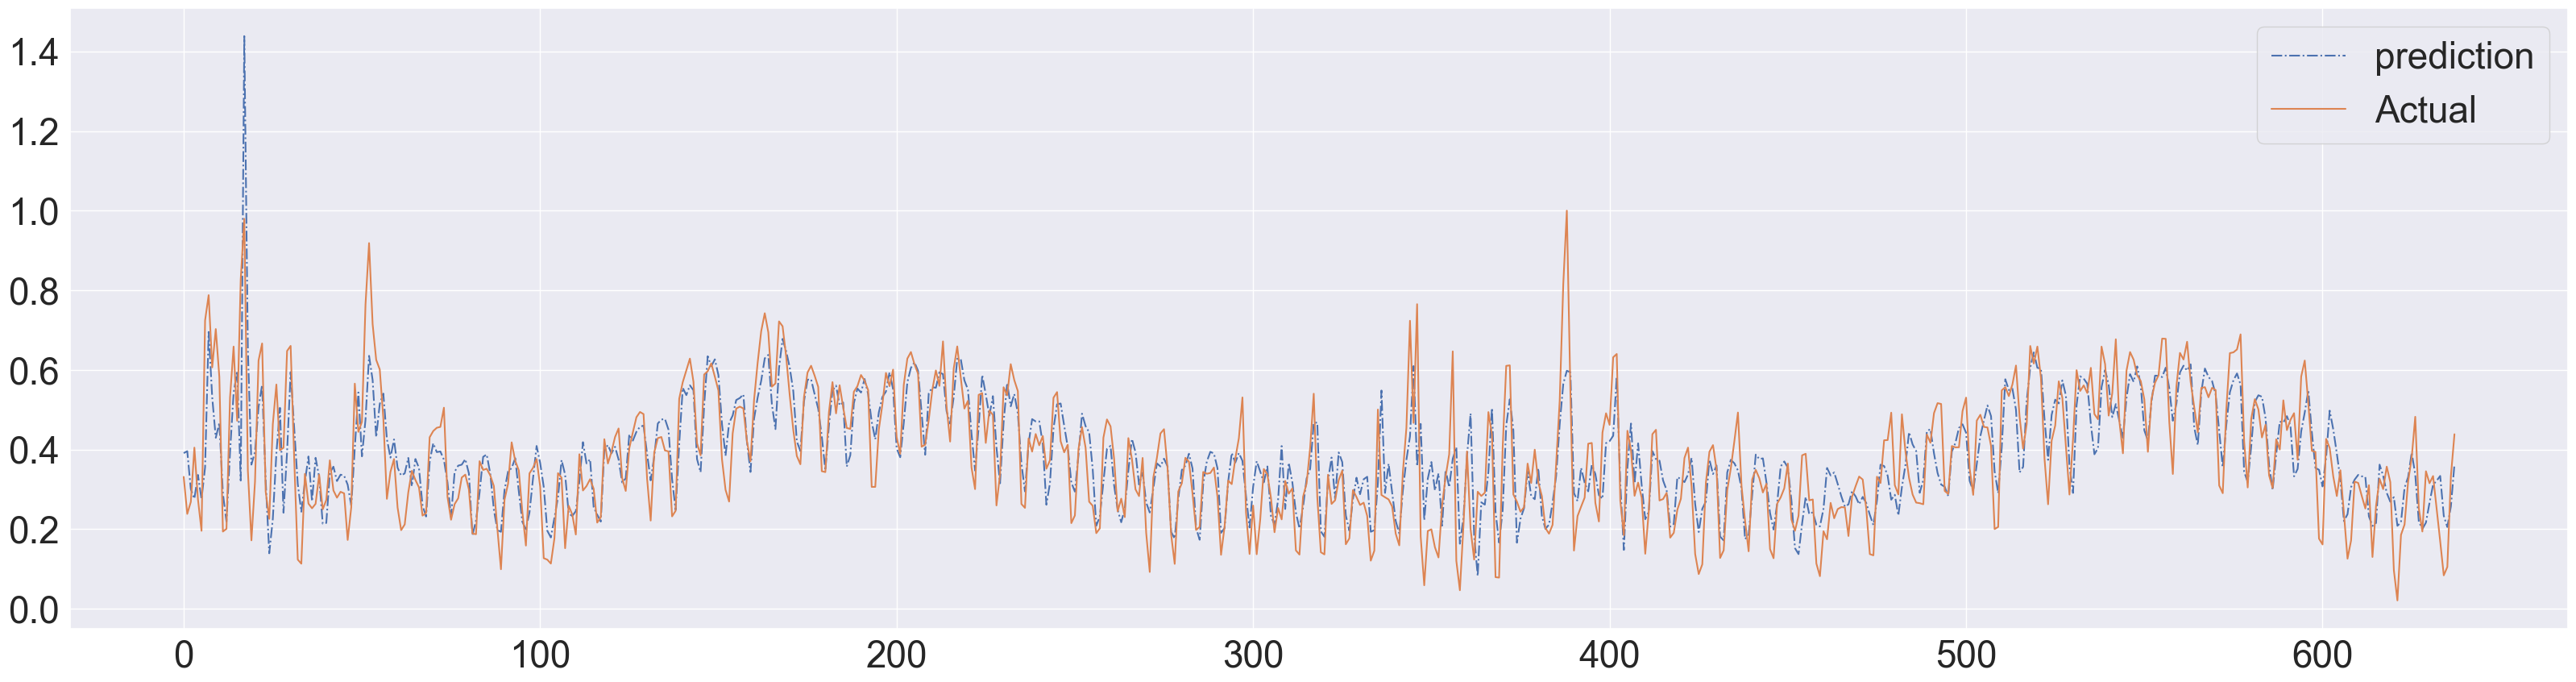

Mean_squared_error: 0.009085522554987537
Mean_absolute_error: 0.07075558800258577
Root mean squared error: 0.09531800750638642


In [93]:
test_prediction = best_LSTM_with_tuner.predict(X_test)
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

Second Attempt of LSTM Hype tuning with less config, batch size 32

In [94]:
def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=192, step=32),
                activation='relu', input_shape=(X.shape[1], X.shape[2]),
                return_sequences=True))
    # for i in range(hp.Int('n_layers', 1, 10)):
    #     model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),
    #                    return_sequences=True))
    model.add(LSTM(hp.Int('lstm_1_units', min_value=32, max_value=96, step=32),
            activation='relu',
            return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse',
                    optimizer=Adam(hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
                    metrics = [RootMeanSquaredError()])
    return model

tuner = BayesianOptimization(
    build_lstm,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    seed=42,
    overwrite=True,
    project_name = 'lstm_tune_1'
)
se = EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[se])

Trial 10 Complete [00h 01m 09s]
val_loss: 0.00975162380685409

Best val_loss So Far: 0.009704229421913624
Total elapsed time: 00h 14m 00s


In [ ]:
# Trial 9 Complete [00h 01m 14s]
# val_loss: 0.009704229421913624

# Best val_loss So Far: 0.009704229421913624
# Total elapsed time: 00h 12m 51s

# Search: Running Trial #10

# Value             |Best Value So Far |Hyperparameter
# 160               |192               |input_unit
# 32                |64                |lstm_1_units
# 0                 |0.1               |Dropout_rate
# 0.001             |0.01              |learning_rate
# 14m 0.1s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 192)            154368    
                                                                 
 lstm_1 (LSTM)               (None, 64)                65792     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 220225 (860.25 KB)
Trainable params: 220225 (860.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
20/20 [==============================] - 0s 6ms/step


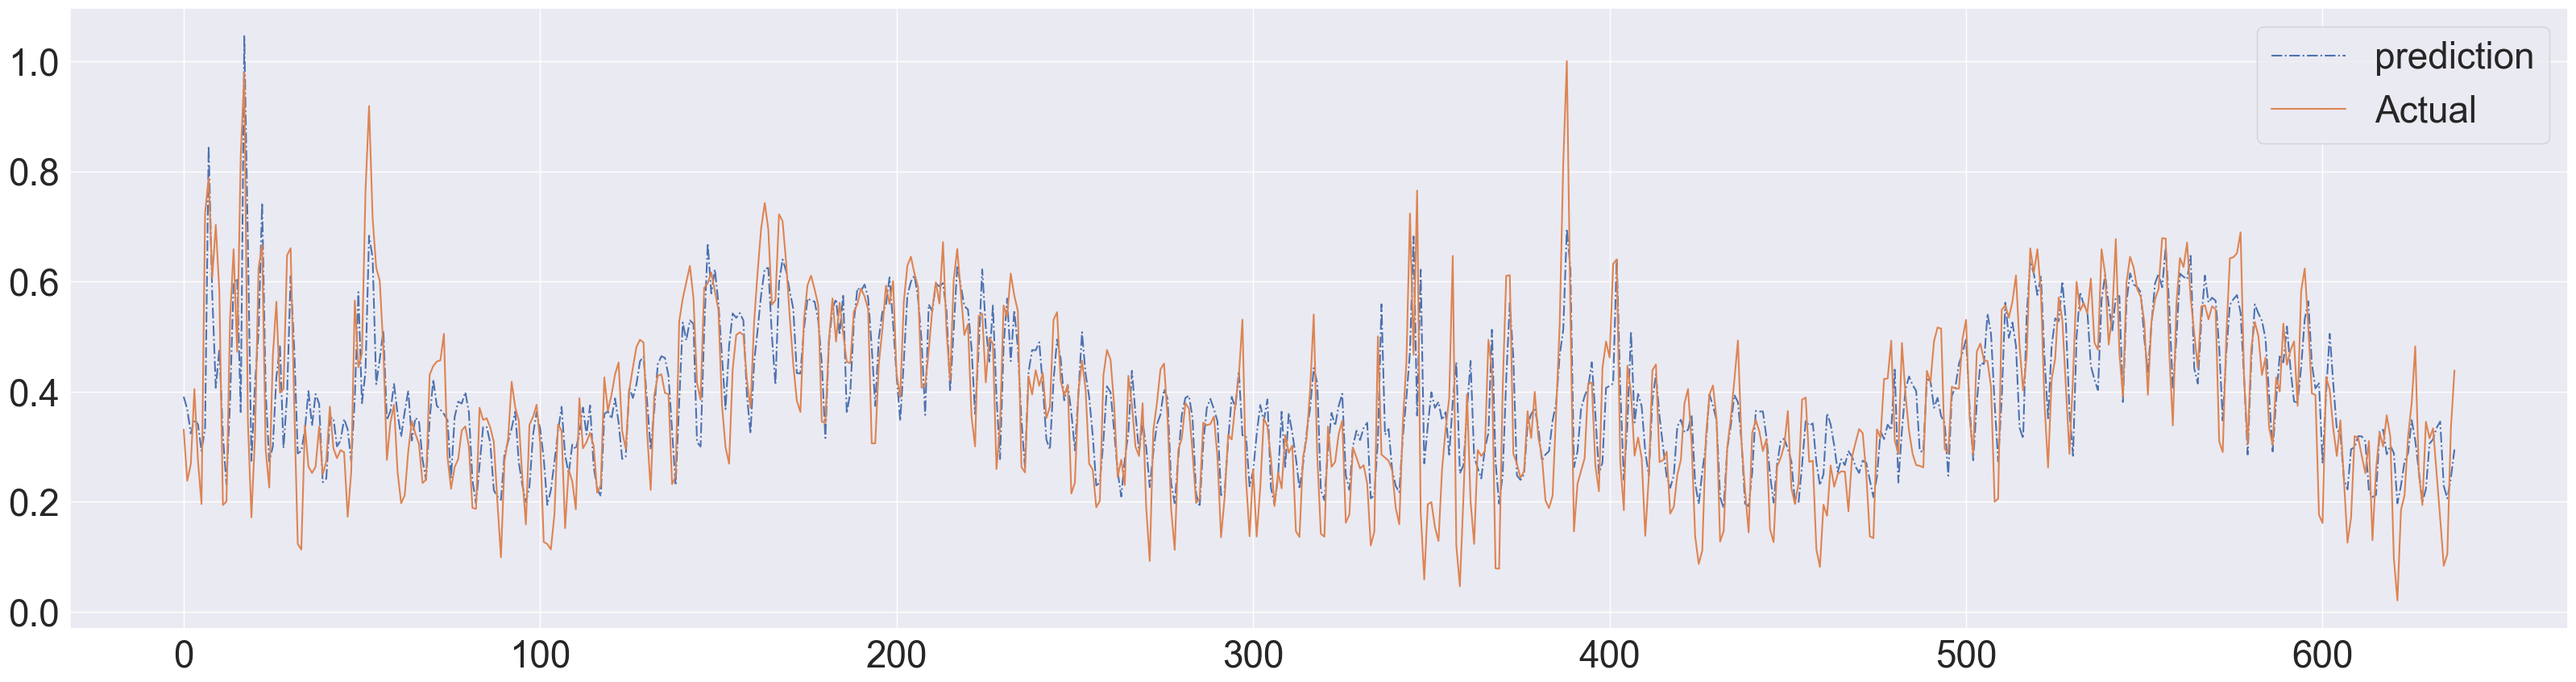

Mean_squared_error: 0.009206523481819393
Mean_absolute_error: 0.07159433912939603
Root mean squared error: 0.09595063043992673


In [95]:
best_LSTM_with_tuner_1 = tuner.get_best_models(num_models=1)[0]
best_LSTM_with_tuner_1.summary()
test_prediction = best_LSTM_with_tuner_1.predict(X_test)
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

Third attempt with input layer 64-192,32; stacked lstm layer 32-64


In [96]:
def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=64, max_value=192, step=32),
                activation='relu', input_shape=(X.shape[1], X.shape[2]),
                return_sequences=True))
    # for i in range(hp.Int('n_layers', 1, 10)):
    #     model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),
    #                    return_sequences=True))
    model.add(LSTM(hp.Int('lstm_1_units', min_value=32, max_value=64, step=32),
            activation='relu',
            return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse',
                    optimizer=Adam(hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
                    metrics = [RootMeanSquaredError()])
    return model

tuner = BayesianOptimization(
    build_lstm,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    seed=42,
    overwrite=True,
    project_name = 'lstm_tune_2'
)
se = EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[se])

Trial 10 Complete [00h 01m 15s]
val_loss: 0.011921596092482408

Best val_loss So Far: 0.009643697490294775
Total elapsed time: 00h 15m 48s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            70144     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 90785 (354.63 KB)
Trainable params: 90785 (354.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
20/20 [==============================] - 0s 5ms/step


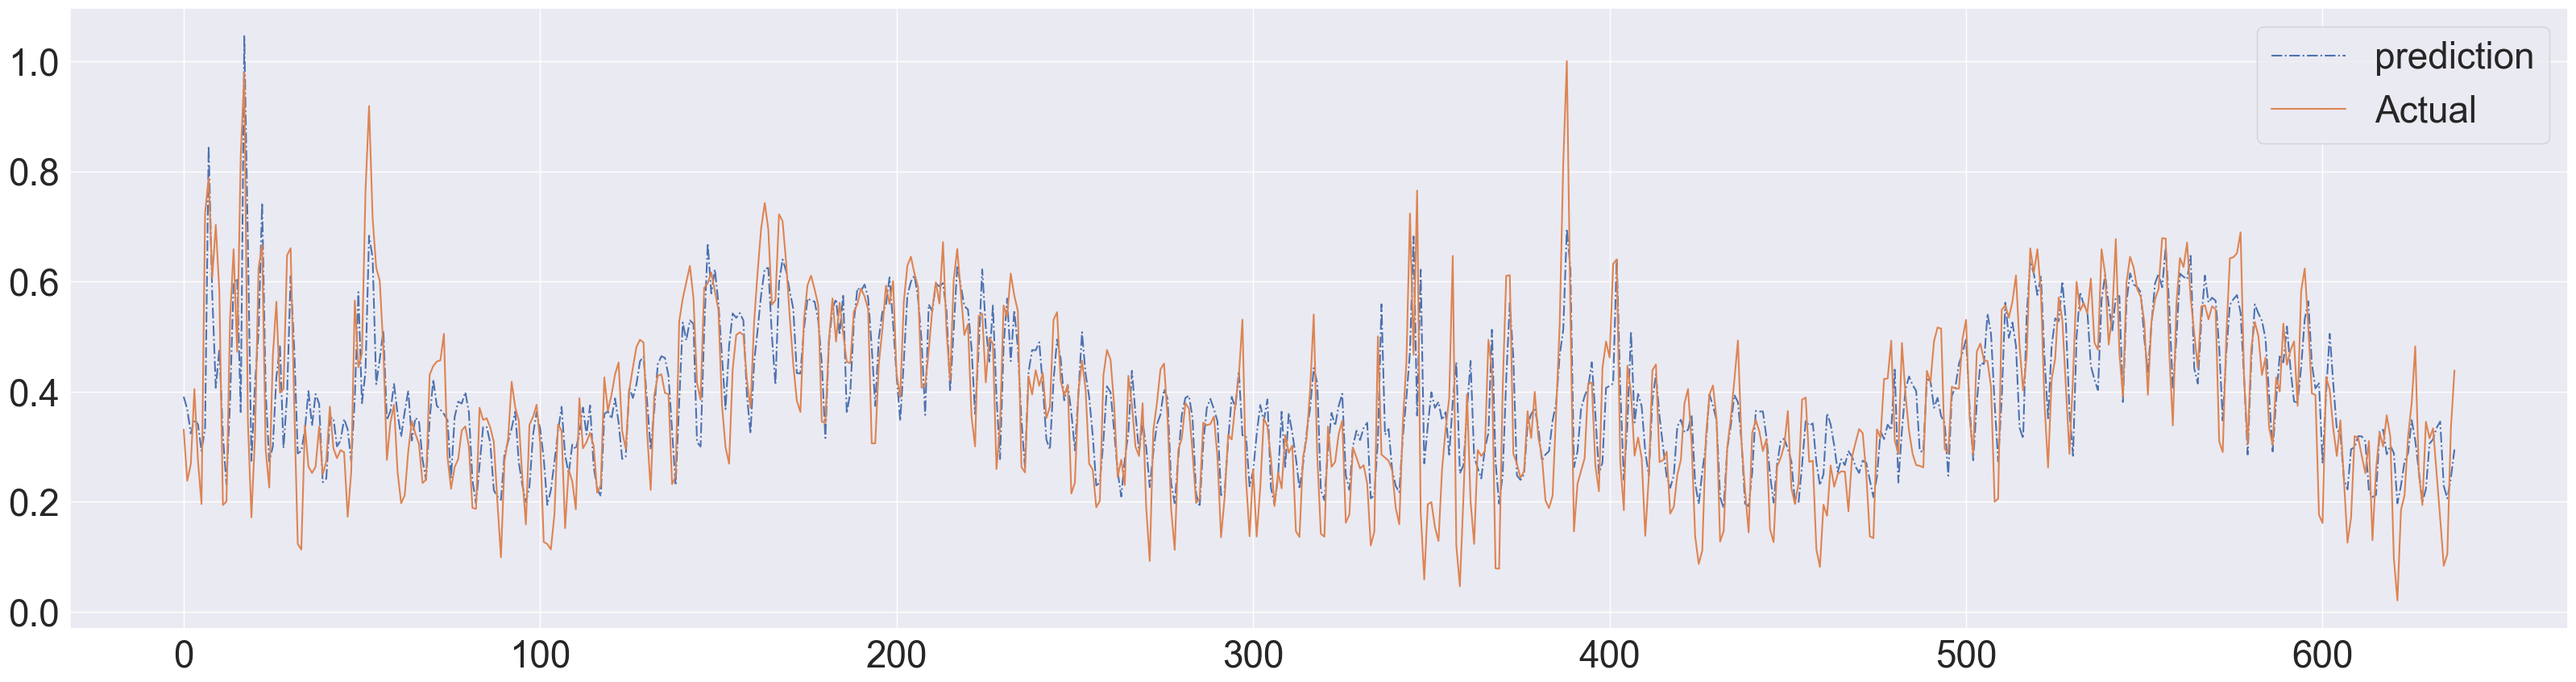

Mean_squared_error: 0.009206523481819393
Mean_absolute_error: 0.07159433912939603
Root mean squared error: 0.09595063043992673


In [97]:
best_LSTM_with_tuner_2 = tuner.get_best_models(num_models=1)[0]
best_LSTM_with_tuner_2.summary()
test_prediction = best_LSTM_with_tuner_2.predict(X_test)
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

In [98]:
def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=64, max_value=192, step=32),
                activation='relu', input_shape=(X.shape[1], X.shape[2]),
                return_sequences=True))
    # for i in range(hp.Int('n_layers', 1, 10)):
    #     model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),
    #                    return_sequences=True))
    model.add(LSTM(hp.Int('lstm_1_units', min_value=32, max_value=64, step=32),
            activation='relu',
            return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse',
                    optimizer=Adam(hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
                    metrics = [RootMeanSquaredError()])
    return model

tuner = RandomSearch(
    build_lstm,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    seed=42,
    overwrite=True,
    project_name = 'lstm_tune_3'
)
se = EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=10,
             validation_data=(X_test, y_test),
             callbacks=[se])

Trial 10 Complete [00h 01m 39s]
val_loss: 0.009403239004313946

Best val_loss So Far: 0.009136070497334003
Total elapsed time: 00h 20m 43s


In [ ]:
# Trial 9 Complete [00h 01m 51s]
# val_loss: 0.009136070497334003

# Best val_loss So Far: 0.009136070497334003
# Total elapsed time: 00h 19m 04s

# Search: Running Trial #10

# Value             |Best Value So Far |Hyperparameter
# 192               |192               |input_unit
# 32                |32                |lstm_1_units
# 0                 |0.1               |Dropout_rate
# 0.001             |0.01              |learning_rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 192)            154368    
                                                                 
 lstm_1 (LSTM)               (None, 32)                28800     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 183201 (715.63 KB)
Trainable params: 183201 (715.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
20/20 [==============================] - 0s 4ms/step


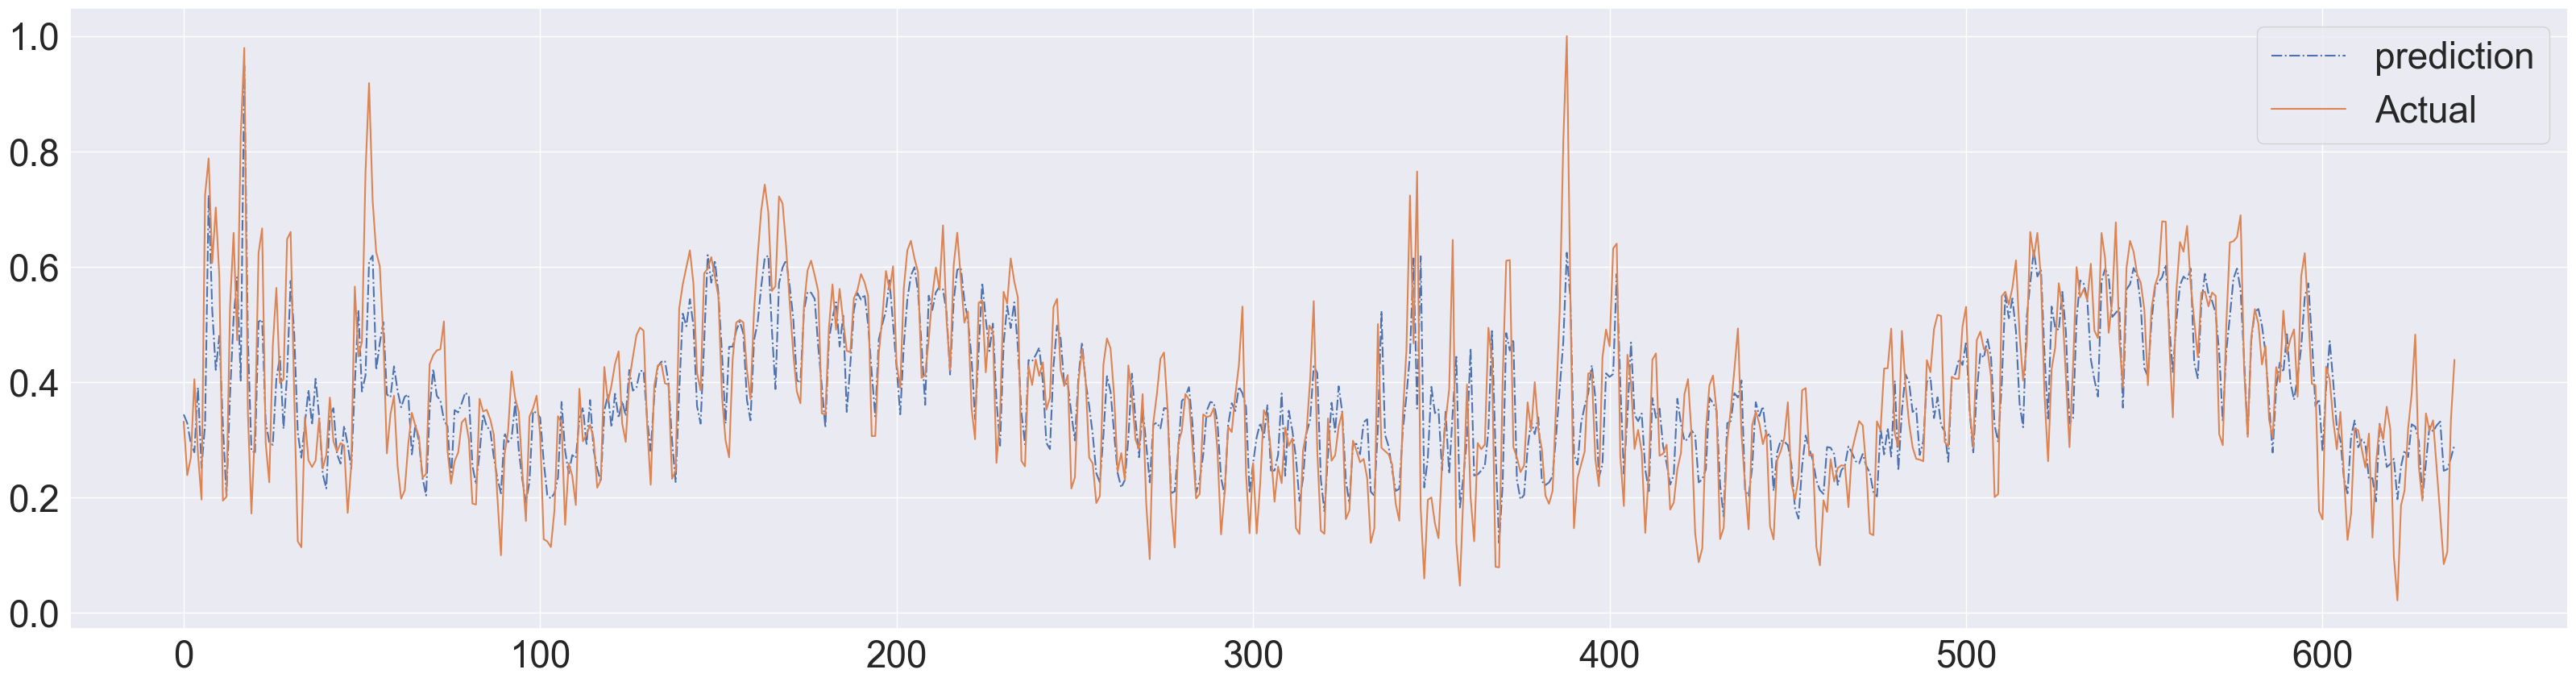

Mean_squared_error: 0.008837393652366037
Mean_absolute_error: 0.06910286418637525
Root mean squared error: 0.09400741275221884


In [101]:
best_LSTM_with_tuner_3 = tuner.get_best_models(num_models=1)[0]
best_LSTM_with_tuner_3.summary()
test_prediction = best_LSTM_with_tuner_3.predict(X_test)
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 192)            154368    
                                                                 
 lstm_5 (LSTM)               (None, 32)                28800     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 183201 (715.63 KB)
Trainable params: 183201 (715.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
139/147 [===========================>..] - ETA: 0s - loss: 0.0342 - root_mean_squared_error: 0.1850INFO:tensorflow:Assets written to: l

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 3s 13ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 2/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1410
Epoch 3/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 4/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1395
Epoch 5/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0185 - root_mean_squared_error: 0.1362 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1402
Epoch 6/50
139/147 [===========================>..] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.1381INFO:tensorflow:Assets written to: lstm_

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1344
Epoch 7/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 8/50
147/147 [==============================] - 1s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 9/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 10/50
144/147 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1171INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 14ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 11/50
142/147 [===========================>..] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.1095INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 12/50
143/147 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.1049INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 13/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 14/50
144/147 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1028INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 15/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.0998 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 16/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 17/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 18/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 19/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0118 - val_root_

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 13ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 23/50
143/147 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0980INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 24/50
142/147 [===========================>..] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0940INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 25/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 26/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0941 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 27/50
146/147 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0927INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 28/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 29/50
146/147 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0907INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 13ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 30/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 31/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 32/50
144/147 [============================>.] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 33/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 34/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 35/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 36/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 37/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0094 - val_root_

INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 12ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 40/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 41/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 42/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 43/50
144/147 [============================>.] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0825INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


INFO:tensorflow:Assets written to: lstm_model_from_tuning\assets


147/147 [==============================] - 2s 13ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 44/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 45/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 46/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 47/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 48/50
147/147 [==============================] - 1s 5ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0098 - val_root_

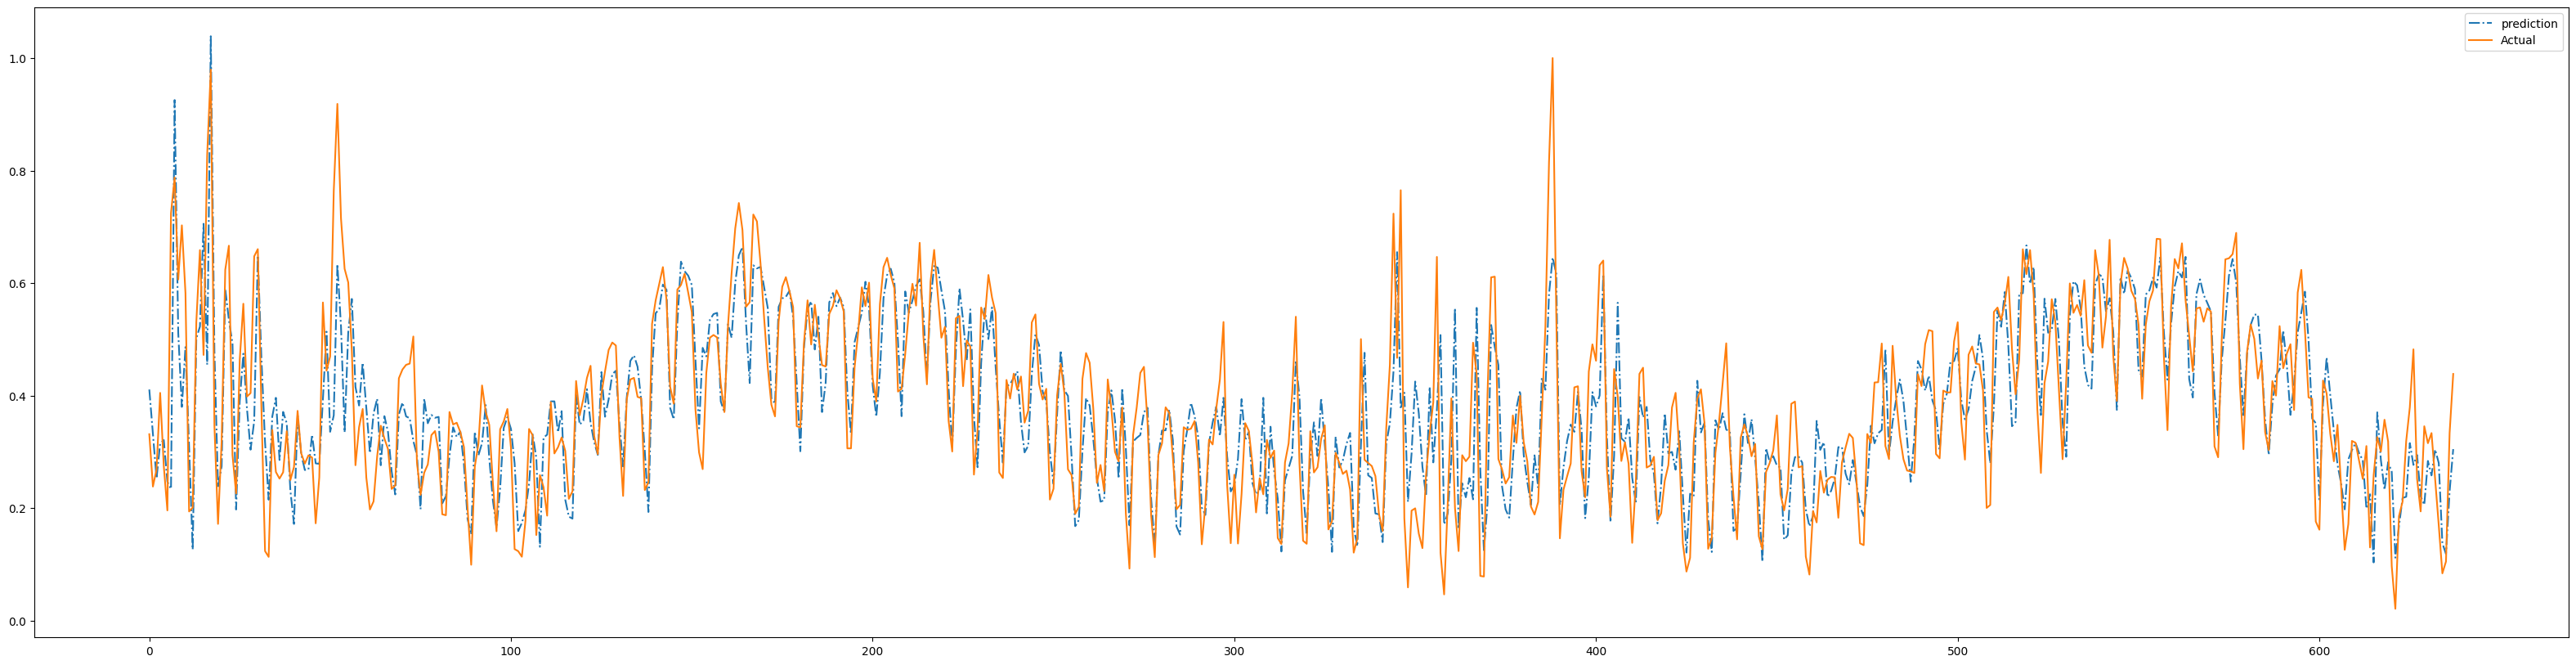

Execution time: 0.18702340126037598 seconds
Mean_squared_error: 0.00848329869005828
Mean_absolute_error: 0.06709475987784952
Root mean squared error: 0.09210482446679044


In [51]:
lstm_model = Sequential()
lstm_model.add(LSTM(192, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences= True))
lstm_model.add(LSTM(32, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(y.shape[1], activation = 'linear'))

lstm_model.summary()
cp = ModelCheckpoint('lstm_model_from_tuning/', save_best_only=True)
lstm_model.compile(loss = 'mse',
                    optimizer=Adam(learning_rate=0.01),
                    metrics = [RootMeanSquaredError()])
lstm_model.fit(X_train, y_train, epochs=50, batch_size= 10, validation_data=(X_test, y_test), verbose= 1, callbacks = [cp])
best_LSTM = load_model('lstm_model_from_tuning/')
lstm_start_time = time.time()
test_prediction = best_LSTM.predict(X_test)
lstm_end_time = time.time()
# train_results = pd.DataFrame(data={'Train_prediction': train_prediction, 'Actual result': y_train})
# train_results
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(test_prediction, linestyle = 'dashdot', label ='prediction')
plt.plot(y_test, label ='Actual')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Execution time:", lstm_end_time - lstm_start_time, "seconds")
print('Mean_squared_error:', mean_squared_error(y_test, test_prediction))
print('Mean_absolute_error:', mean_absolute_error(y_test, test_prediction))
print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, test_prediction)))